## LLM Dev Chat 

This notebook is not part of the midi-rae nbdev3 project, i.e. it is not intended to be distributed, rather this is for the development of the project with the help of an LLM.

Goal of this project is to create a representation autoencoder as per the RAE paper: https://arxiv.org/html/2510.11690v1
For this project we will be working with MIDI piano roll images, training our own encoder and decoder and writing the diffusion transformer for generative modeling.

Unlike the original RAE paper, we can't just use a pre-trained encoder like DinoV2 due to the OOD nature of our images.

To keep the representation from collapsing, we're using LeJEPA, which you can see a summary of at my toy model page: https://www.scotthawley.com/ssltoy/

I've also introduced some curriculum learning to make it easier for the model at early stages of training. And we keep we use the differences in the crop locations , aka "deltas" in the attraction part of the Legeppa loss, so that crops that are closer to each other experience a stronger attraction than crops that are farther away from each other.


In [ ]:
!ls midi_rae/*.py 

midi_rae/__init__.py  midi_rae/data.py	   midi_rae/train.py
midi_rae/_modidx.py   midi_rae/encoder.py  midi_rae/utils.py
midi_rae/core.py      midi_rae/lejepa.py   midi_rae/viz.py


Hello. I recommend scraping the two URLs above just to get a sense of what we're trying to do.

Next up, we need to train the decoder on a reconstruction objective, and then we can train the generative model, the diffusion transformer -- Or do I have that backwards?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>read_url(url='https://arxiv.org/html/2510.11690v1')</summary>

```json
{
  "id": "toolu_01XWiXozmQuWo3S3YddYpGxM",
  "call": {
    "function": "read_url",
    "arguments": {
      "url": "https://arxiv.org/html/2510.11690v1"
    }
  },
  "result": "'1. [1 Introduction](https://arxiv.org/html/2510.11690v1#S1 \"In Diffusion Transformers with Representation Autoencoders\")\\n  2. [2 Related works](https://arxiv.org/html/2510.11690v1#S2 \"In Diffusion Transformers with Representation Autoencoders\")\\n  3. [3 High Fidelity Reconstruction from Frozen Encoders](https://arxiv.org/html/2510.11690v1#S3 \"In Diffusion Transformers with Representation Autoencoders\")\\n     1. [Reconstruction, scaling, and representation.](https://arxiv.org/html/2510.11690v1#S3.SS0.SSS0.Px1 \"In 3 High Fidelity Reconstruction from Frozen Encoders \u2023 Diffusion Transformers wit<TRUNCATED>"
}
```

</details>



<details class='tool-usage-details'>
<summary>read_url(url='https://www.scotthawley.com/ssltoy/')</summary>

```json
{
  "id": "toolu_014aUmBVj7vq1SQFTaiD6j3b",
  "call": {
    "function": "read_url",
    "arguments": {
      "url": "https://www.scotthawley.com/ssltoy/"
    }
  },
  "result": "'## Self-Supervised Learning demo - TensorFlow.js with Autograd\\n\\n\ud83c\udf19\\n\\n\u23ee \u25b6 \u23f8\\n\\nAlgorithm: Pairwise CL (+/-) Attract+Rescale VICReg LeJEPA # Steps: Learning rate:\\n\\n# Objects: Data manifold: None X Swiss Roll 2D Latents Operate on: Embeddings Encoder Embed dim:\\n\\nNormalize: No L2 L1 Margin:\\n\\nLinear Constant\\n\\nThis demo creates \"views\" of objects by adding jitter noise, then trains an embedding to draw similar views together while avoiding collapse.   \\n  \\nFor LeJEPA, a extra predictor network is optional (not needed for this demo).   \\n  \\nLearn more about how it works \u2193\\n\\nThe 3D plot <TRUNCATED>"
}
```

</details>

Thanks for the context! I've now read both papers.

**Quick summary:**
- The RAE paper trains: 1) a decoder on reconstruction, 2) then the diffusion transformer (DiT) for generation
- Your LeJEPA approach uses the Epps-Pulley test for SIGReg to prevent representation collapse

**To answer your question:** You have the order right! The standard pipeline is:

1. **Train encoder** (your LeJEPA) - you've already done this
2. **Train decoder** on reconstruction - freeze encoder, train decoder to reconstruct images from the frozen encoder's representations  
3. **Train diffusion transformer** - operates in the latent space of your frozen encoder

The decoder training is a prerequisite for the diffusion model because you need to decode the generated latents back to images.

Where are you in this pipeline currently? Have you completed the encoder training, and are you ready to start on the decoder?

I've been doing various runs to train the encoder, and I wouldn't say that it's totally finished, but by the time we finish writing the decoder, I will definitely have a variety of encoder checkpoints to choose from.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

That's a smart approach — working on the decoder in parallel while encoder training continues.

Let me take a quick look at your existing codebase to see what you're working with:

<details class='tool-usage-details'>
<summary>view(path='midi_rae/encoder.py')</summary>

```json
{
  "id": "toolu_015o1YUMMx7D8ukVUbumwHvu",
  "call": {
    "function": "view",
    "arguments": {
      "path": "midi_rae/encoder.py"
    }
  },
  "result": "'\"\"\"encoder/ViT definition\"\"\"\\n\\n# AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/02_encoder.ipynb.\\n\\n# %% auto #0\\n__all__ = [\\'PatchEmbedding\\', \\'RoPE2D\\', \\'Attention\\', \\'TransformerBlock\\', \\'ViT\\']\\n\\n# %% ../nbs/02_encoder.ipynb #b96051a7\\nimport torch\\nimport torch.nn as nn\\nimport torch.nn.functional as F \\n\\n# %% ../nbs/02_encoder.ipynb #a164c279\\nclass PatchEmbedding(nn.Module):\\n    def __init__(self, \\n                in_channels=1,  # 1 for solo piano, for midi PR\\'s, = # of instruments\\n                patch_size=16,  # assuming square patches, e.g. 16 implies 16x16\\n       <TRUNCATED>"
}
```

</details>

Good, I can see your ViT encoder architecture. Now let me check if you have any decoder work started:

<details class='tool-usage-details'>
<summary>rg(argstr='-l decoder midi_rae/')</summary>

```json
{
  "id": "toolu_01BL3EsiyKxGJGnQvoeM5hi5",
  "call": {
    "function": "rg",
    "arguments": {
      "argstr": "-l decoder midi_rae/"
    }
  },
  "result": "''"
}
```

</details>



<details class='tool-usage-details'>
<summary>view(path='nbs')</summary>

```json
{
  "id": "toolu_01UuZ2YP3giYDhdR6V5iy84P",
  "call": {
    "function": "view",
    "arguments": {
      "path": "nbs"
    }
  },
  "result": "'Directory contents of /app/data/midi-rae/nbs:\\n/app/data/midi-rae/nbs/06_train.py (4.9k)\\n/app/data/midi-rae/nbs/_quarto.yml (0.3k)\\n/app/data/midi-rae/nbs/05_viz.ipynb (8.1k)\\n/app/data/midi-rae/nbs/03_lejepa.ipynb (5.4k)\\n/app/data/midi-rae/nbs/04_utils.ipynb (2.7k)\\n/app/data/midi-rae/nbs/00_core.ipynb (1.0k)\\n/app/data/midi-rae/nbs/02_encoder.ipynb (9.4k)\\n/app/data/midi-rae/nbs/01_data.ipynb (35.4k)\\n/app/data/midi-rae/nbs/06_train.ipynb (7.5k)\\n/app/data/midi-rae/nbs/styles.css (0.6k)\\n/app/data/midi-rae/nbs/index.ipynb (4.1k)\\n/app/data/midi-rae/nbs/nbdev.yml (0.2k)\\n/app/data/midi-rae<TRUNCATED>"
}
```

</details>

No decoder yet — perfect, we're starting fresh!

Your encoder outputs either:
- **CLS token only**: shape `(B, dim)` — a single vector per image
- **All tokens**: shape `(B, num_patches+1, dim)` — CLS + patch tokens

**Key question:** For the decoder, do you want to reconstruct from:
1. **Just the CLS token** (more compressed, harder reconstruction task), or
2. **All patch tokens** (more information, easier reconstruction)?

The RAE paper uses patch tokens (not just CLS), which makes sense since patch-level representations carry spatial information that a DiT can work with.

What's your preference?

Well, for the encoder training, we haven't been using any of the patches. We've only used the CLS token. Because I thought, well, I just want one 768 dimensional vector to represent the embedding of the image. So while we could use the patch tokens, uh I don't think they've been trained towards any objective, so they could be kinda random. If you have an idea for training the encoder in a way that will include the patch tokens with the Legeppa loss, let me know. It was just a matter of getting the dimensions right, to be honest.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Ah, that's a crucial point! If only the CLS token has been trained with the LeJEPA loss, the patch tokens are essentially untrained and won't carry meaningful spatial information.

**Two paths forward:**

1. **Decoder from CLS only** — This is doable but harder. You'd need a decoder that "unpacks" a single 768-d vector back to a full image. Think of it like a GAN generator or a learned upsampler.

2. **Modify LeJEPA to train patch tokens** — The key insight: when two crops overlap spatially, the patch tokens corresponding to the *same* region should be attracted. You'd compute which patches overlap based on crop coordinates, then apply the attraction loss between those corresponding patches (using the same delta-weighted approach you already have for CLS).

Option 2 would give you richer representations for generation, but it's more work on the encoder side.

Which direction interests you more?

Well one of the key aspects of the RAE was that it wasn't really compressing much. What does DIVOV2 output as an encoder? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great question! DINOv2 outputs **both** a CLS token and patch tokens:

- For ViT-L/14 on 224×224 images: **(B, 257, 1024)** — that's 1 CLS + 256 patch tokens (16×16 grid)
- For ViT-B/14: **(B, 257, 768)**

The RAE paper uses the **patch tokens** (not just CLS) as the latent representation. So for a 16×16 grid with 1024-d embeddings, that's 256×1024 = **262k dimensions** — barely any compression from the original image!

That's a key insight: RAE relies on the *structure* of the representation (semantically meaningful patches) rather than aggressive compression. The DiT then operates on this patch grid.

This suggests if you want to follow the RAE approach closely, training your patch tokens would be valuable. Otherwise you'd be doing something more novel — generating from a highly compressed CLS-only representation.

Okay, so retraining my encoder, I can do that. But do the patches actually overlap in the VIT or are they disjoint?  Check my encoder code, e.g that patchembedding routine with the Conv2D

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>view(path='midi_rae/encoder.py', view_range=[1, 50])</summary>

```json
{
  "id": "toolu_01QYZ7qGkJrGdBx6i7fNKVAJ",
  "call": {
    "function": "view",
    "arguments": {
      "path": "midi_rae/encoder.py",
      "view_range": "[1, 50]"
    }
  },
  "result": "'\"\"\"encoder/ViT definition\"\"\"\\n\\n# AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/02_encoder.ipynb.\\n\\n# %% auto #0\\n__all__ = [\\'PatchEmbedding\\', \\'RoPE2D\\', \\'Attention\\', \\'TransformerBlock\\', \\'ViT\\']\\n\\n# %% ../nbs/02_encoder.ipynb #b96051a7\\nimport torch\\nimport torch.nn as nn\\nimport torch.nn.functional as F \\n\\n# %% ../nbs/02_encoder.ipynb #a164c279\\nclass PatchEmbedding(nn.Module):\\n    def __init__(self, \\n                in_channels=1,  # 1 for solo piano, for midi PR\\'s, = # of instruments\\n                patch_size=16,  # assuming square patches, e.g. 16 implies 16x16\\n       <TRUNCATED>"
}
```

</details>

Your patches are **disjoint** (non-overlapping). The key line is:

```python
self.conv = nn.Conv2d(in_channels, dim, kernel_size=patch_size, stride=patch_size)
```

Since `kernel_size == stride`, each patch is extracted without overlap — this is standard ViT behavior.

However, for the LeJEPA training, the **crops** (the random windows you take from the image) can overlap even though the patches within each crop are disjoint. So when two crops partially cover the same region of the original image, some of their patch tokens will correspond to the same spatial locations.

Does that clarify things? The patch-level LeJEPA loss would match patches from different crops that map to the same original image coordinates.

Oh, okay. So this isn't really that bad, coding-wise. It's kind of like we're just going to multiply the number of tokens we have going into LeJEPA by a...lot.  Right now we've got a really big batch size of 640, but I suspect we'll probably need to lower that if we do all the patch tokens.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Exactly right. If you have a 16×16 patch grid, that's 256× more tokens to process in the loss computation. Going from 640 × 1 CLS to 640 × 256 patches is a big jump.

A few options to manage memory:

1. **Reduce batch size** (as you said)
2. **Only compute patch loss on overlapping patches** — skip pairs that don't correspond spatially
3. **Subsample patches** — randomly pick a subset of patches for the loss each step

What crop size are you using, and what's your image size? That'll determine how many patches per crop you're actually dealing with.

Well, sorry, hang on a second. So, all the crops are going to overlap. In fact, they're mostly going to overlap, which means the patches are also going to mostly overlap. The largest shifts I have are plus or minus 12, and if they're 16 by 16, okay, well, yeah, maybe sometimes the overlap won't be that big, but uh One other thing we might do is add gradient checkpointing to various forward methods.?
And we could do some kind of accumulation so that the Le Jepa statistics are still. Oh, no, no, it's fine. We'll definitely have plenty of points in Le Jepa. It's just a question of how many images those points will correspond to.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Right, with ±12 shifts and 16×16 patches, you'll still have substantial overlap in most cases. And yes — gradient checkpointing on the transformer blocks would help a lot with memory.

Your point about statistics is spot on: even if batch size drops to, say, 64 images, you'd have 64 × 256 = 16k patch tokens for LeJEPA. Plenty for robust covariance estimates.

So it sounds like you have a reasonable path forward for encoder training with patch tokens. 

**Question:** Do you want to tackle the encoder modifications first, or would you prefer to start building the decoder architecture in parallel (assuming you'll eventually have patch-level representations to work with)?

In [ ]:
640/256

2.5

Uh are we gonna need to lower the batch size all the way down to two to make it fit on my GPU?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Not necessarily that drastic! The encoder forward pass memory doesn't change — you're processing the same images either way. The extra cost is:

1. **Storing** all patch tokens instead of discarding them (relatively small)
2. **LeJEPA loss computation** on more tokens (this is the bigger one)

With gradient checkpointing on your transformer blocks, you'd recover a lot of the activation memory. You might get away with batch sizes like 32-64 rather than 2.

What GPU are you on, and how much VRAM is currently used at batch size 640?

I have a 4090 GPU with 24 GB of ram, currently using 81% So, a lot of that is kind of boilerplate and is not exactly the batch size. With a very small batch size, we're probably at 40%. So, the other 40% is coming from our batches. Uh I think, I mean, I can double check.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

So roughly:
- ~40% baseline (~9.6 GB)
- ~40% from batches (~9.6 GB)

The good news: your encoder already computes all 256 patch tokens — it just discards them before the loss. So the forward pass memory stays the same.

The extra cost is in LeJEPA loss computation on 256× more tokens. How expensive that is depends on how the loss is structured — are you computing full covariance matrices? That could scale quadratically with token count.

Want to check your `lejepa.py` to see how the loss scales?

Yeah, why don't you take a look? We do not compute covariance matrices. You might be thinking of Vicreg. Le Jeppa relies on Eps pulley test using random hyperplanes.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>view(path='midi_rae/lejepa.py')</summary>

```json
{
  "id": "toolu_01UEZyE9gdk3FhVoLAr7b7y2",
  "call": {
    "function": "view",
    "arguments": {
      "path": "midi_rae/lejepa.py"
    }
  },
  "result": "'\"\"\"LeJEPA definition\"\"\"\\n\\n# AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/03_lejepa.ipynb.\\n\\n# %% auto #0\\n__all__ = [\\'SIGReg\\', \\'attraction_loss\\', \\'LeJEPA\\']\\n\\n# %% ../nbs/03_lejepa.ipynb #b96051a7\\nimport torch\\n\\n# %% ../nbs/03_lejepa.ipynb #a164c279\\ndef SIGReg(x, global_step, num_slices=256):\\n    \"\"\"SIGReg with Epps-Pulley statistic. x is (N, K) tensor.\"\"\"\\n    device = x.device\\n    g = torch.Generator(device=device).manual_seed(global_step)\\n    proj_shape = (x.size(1), num_slices)\\n    A = torch.randn(proj_shape, generator=g, device=device)\\n    A = A / (A.norm(dim=0, keepd<TRUNCATED>"
}
```

</details>

Ah nice, you're right! The SIGReg computation is linear in N (batch size) — no covariance matrices. The main costs are:

1. `x @ A` — (N, K) × (K, 256) = O(N × K × num_slices)
2. `torch.cat((z1, z2))` — doubling the tokens

With patch tokens, if you go from N=640 CLS tokens to N=640×256 patch tokens... that `torch.cat` would give you ~328k tokens going into SIGReg. The projection and ECF ops would scale linearly with that.

It's not quadratic, so that's good! But 256× more tokens is still substantial. Gradient checkpointing + modest batch reduction (maybe 32-64 images?) should keep you in a workable range.

Want to try a quick test run with patches to see actual memory usage?

Yeah, in fact, um so all we're going to need to do when we call the encoder is just pass in whatever that quarg is to say, give me the full set of embeddings, and then we'll just have to kind of manage the shapes. If we just stack up all the different patch embeddings, then we can still have a (batch_size*2*256, 768) Tensor that we pass into Le Jeppa. And I think everything should be okay from there.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

That should work for SIGReg — it just wants a (N, K) tensor and doesn't care about structure.

But what about `attraction_loss`? Currently it pairs up CLS tokens from the same image. With patches, do you want:

1. **All patches from same image attract** (simple reshape, but doesn't use spatial info), or
2. **Only spatially-corresponding patches attract** (uses your delta/distance weighting based on actual patch positions)?

Option 2 would give richer training signal but needs you to track which patches overlap. Option 1 is the quick path to test memory usage.

Which way do you want to go?

Yeah, no, the the patches are already set up to be embedding one and embedding two, so really I think it's gonna be fine.  If we just take all the patch embeddings and vertically stack them where the CLS token used to be, it should just work.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You're right — if the two crops have small shifts (±12), then patch i from crop 1 roughly corresponds to patch i from crop 2. The existing pairing logic should work without modification.

Want to do a quick test run to check memory? Just change the encoder call to return all tokens and reshape before passing to LeJEPA.

No, sorry, maybe I wasn't clear. I want you to actually tell me which modifications I need to make to the code. I forgot what the quarg is to get me to get the encoder to spit out the full tensor and then just the logic for reshaping things. So take a look in the encoder code and take a look in the training code. I suspect we're really only going to need to modify a few lines of code.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>view(path='midi_rae/encoder.py')</summary>

```json
{
  "id": "toolu_01GZBSno4ZErm4hATkZudXsK",
  "call": {
    "function": "view",
    "arguments": {
      "path": "midi_rae/encoder.py"
    }
  },
  "result": "'\"\"\"encoder/ViT definition\"\"\"\\n\\n# AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/02_encoder.ipynb.\\n\\n# %% auto #0\\n__all__ = [\\'PatchEmbedding\\', \\'RoPE2D\\', \\'Attention\\', \\'TransformerBlock\\', \\'ViT\\']\\n\\n# %% ../nbs/02_encoder.ipynb #b96051a7\\nimport torch\\nimport torch.nn as nn\\nimport torch.nn.functional as F \\n\\n# %% ../nbs/02_encoder.ipynb #a164c279\\nclass PatchEmbedding(nn.Module):\\n    def __init__(self, \\n                in_channels=1,  # 1 for solo piano, for midi PR\\'s, = # of instruments\\n                patch_size=16,  # assuming square patches, e.g. 16 implies 16x16\\n       <TRUNCATED>"
}
```

</details>



<details class='tool-usage-details'>
<summary>view(path='midi_rae/train.py')</summary>

```json
{
  "id": "toolu_01ERhqvCgGVxfWfqDmiqoYuQ",
  "call": {
    "function": "view",
    "arguments": {
      "path": "midi_rae/train.py"
    }
  },
  "result": "'\"\"\"Training script for midi_rae\"\"\"\\n\\n# AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/06_train.ipynb.\\n\\n# %% auto #0\\n__all__ = [\\'curr_learn\\', \\'train\\']\\n\\n# %% ../nbs/06_train.ipynb #98edfbef\\nimport os\\nimport torch\\nimport torch.nn as nn\\nfrom torch.utils.data import DataLoader\\nimport wandb\\nfrom hydra import compose, initialize\\nfrom omegaconf import DictConfig, OmegaConf\\nimport hydra\\nfrom .encoder import ViT\\nfrom .data import PRPairDataset\\nfrom .lejepa import LeJEPA\\nfrom .utils import save_checkpoint\\nfrom .viz import make_emb_viz\\nfrom tqdm.auto import tqdm\\nimport multipro<TRUNCATED>"
}
```

</details>

The encoder already has the kwarg you need: `return_cls_only=True` (default). Pass `return_cls_only=False` to get all tokens.

In `train.py`, the relevant lines are ~63-64 and ~73-74:

```python
z1 = model(img1) 
z2 = model(img2)
```

**Changes needed:**

1. Pass `return_cls_only=False`:
```python
z1 = model(img1, return_cls_only=False)  # (B, 257, 768) - CLS + 256 patches
z2 = model(img2, return_cls_only=False)
```

2. Reshape to stack all tokens (excluding CLS, or including it — your call):
```python
z1 = z1[:, 1:].reshape(-1, z1.shape[-1])  # (B*256, 768) - patches only
z2 = z2[:, 1:].reshape(-1, z2.shape[-1])
```

That's it — LeJEPA should work from there. Same two changes needed in the validation loop.

Want to include CLS in the loss too, or just patches?

Yeah, I mean, the CLS is not that much harder to include, so we'll leave it in. 


....Alright, I made those changes. Can you rescrape the training Python code and let me know what you think of my changes?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>view(path='midi_rae/train.py')</summary>

```json
{
  "id": "toolu_016WwUikwUDw8TpA2WKxuMFC",
  "call": {
    "function": "view",
    "arguments": {
      "path": "midi_rae/train.py"
    }
  },
  "result": "'\"\"\"Training script for midi_rae\"\"\"\\n\\n# AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/06_train.ipynb.\\n\\n# %% auto #0\\n__all__ = [\\'curr_learn\\', \\'train\\']\\n\\n# %% ../nbs/06_train.ipynb #98edfbef\\nimport os\\nimport torch\\nimport torch.nn as nn\\nfrom torch.utils.data import DataLoader\\nimport wandb\\nfrom hydra import compose, initialize\\nfrom omegaconf import DictConfig, OmegaConf\\nimport hydra\\nfrom .encoder import ViT\\nfrom .data import PRPairDataset\\nfrom .lejepa import LeJEPA\\nfrom .utils import save_checkpoint\\nfrom .viz import make_emb_viz\\nfrom tqdm.auto import tqdm\\nimport multipro<TRUNCATED>"
}
```

</details>

Looks good! You've got `return_cls_only=False` in all four places, and the reshape to flatten tokens. 

One thing: your `deltas.repeat_interleave(257, dim=0)` — this replicates the same delta for all 257 tokens from each image. That means all patches from a pair get the same attraction weight, which is fine as a starting point.

Ready to test memory usage with a smaller batch size?

Hmm, well, I thought that these things would all match up properly, but here's what we ended up with: 

```
Traceback (most recent call last):
  File "/home/shawley/github/midi-rae/midi_rae/train.py", line 79, in train
    loss = LeJEPA(z1, z2, global_step, deltas=deltas, lambd=cfg.training.lambd)
  File "/home/shawley/github/midi-rae/midi_rae/lejepa.py", line 44, in LeJEPA
    sim = attraction_loss(z1, z2, deltas=deltas)
  File "/home/shawley/github/midi-rae/midi_rae/lejepa.py", line 39, in attraction_loss
    return ((z1 - z2).square() * delta_fac.unsqueeze(-1) ).mean()
RuntimeError: The size of tensor a (2080) must match the size of tensor b (8224) at non-singleton dimension 0
```
I changed the batch size to 32.  32*257 = 8224.  I don't know where that 2080 is coming from though. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

That 2080 is strange. Let's debug the shapes. Can you add a quick print before the LeJEPA call:

```python
print(f"z1: {z1.shape}, z2: {z2.shape}, deltas: {deltas.shape}")
```

That'll tell us where the mismatch is coming from. My guess is deltas might be shaped differently than expected from the dataloader or `curr_learn`.

ok here's the code :
```python
def attraction_loss(z1, z2,  # embeddings of two "views" of the same thing (in batches)
                    deltas=None,   # optional/TBD: info on semantic 'distance' between z1 & z2
                    tau = 100.0):    # inverse strength of fall-off for delta distances, big=slower
    "How we pull similar 'views' together"
    if deltas is None: return (z1 - z2).square().mean()
    delta_diag = (deltas**2).sum(dim=1)
    delta_fac = torch.exp(-delta_diag / tau).unsqueeze(-1) # less attraction for more 'distant' views
    #delta_fac = 1/(1 + delta_diag/tau)  # longer tail than exp
    print(f"z1: {z1.shape}, z2: {z2.shape}, deltas: {deltas.shape}, delta_fac: {delta_fac.shape}")
    return ((z1 - z2).square() * delta_fac).mean()
```
and Here's the output:

```
Epoch 1/1000:   0%|                                                                                        | 0/2556 [00:00<?, ?it/s]z1: torch.Size([2080, 768]), z2: torch.Size([2080, 768]), deltas: torch.Size([8224, 2]), delta_fac: torch.Size([8224, 1])
Epoch 1/1000:   0%|                                                                                        | 0/2556 [00:00<?, ?it/s]
Error executing job with overrides: []
Traceback (most recent call last):
  File "/home/shawley/github/midi-rae/midi_rae/train.py", line 79, in train
    loss = LeJEPA(z1, z2, global_step, deltas=deltas, lambd=cfg.training.lambd)
  File "/home/shawley/github/midi-rae/midi_rae/lejepa.py", line 45, in LeJEPA
    sim = attraction_loss(z1, z2, deltas=deltas)
  File "/home/shawley/github/midi-rae/midi_rae/lejepa.py", line 40, in attraction_loss
    return ((z1 - z2).square() * delta_fac).mean()
RuntimeError: The size of tensor a (2080) must match the size of tensor b (8224) at non-singleton dimension 0



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

The z1/z2 have 2080 = 32 × 65 tokens. That's 64 patches + 1 CLS, meaning your crops are 128×128 (giving an 8×8 patch grid), not 256×256.

The `repeat_interleave(257, dim=0)` is hardcoded for 16×16 patches. You need to compute the actual token count:

```python
num_tokens = z1.shape[0] // batch_size  # or z1.shape[0] // deltas.shape[0] before repeat
```

Where in your training code is the `repeat_interleave(257, ...)`? That's what needs to match the actual token count.

Okay, and the fact that 257 isn't a nice multiple of 256 shouldn't matter, right? This is the batch dimension. There's no GPU optimization on the batch dimension, is there?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Correct — 257 is fine. GPU tensor core optimizations care about the matrix multiplication dimensions (typically wanting multiples of 8 or 16), but the batch dimension can be arbitrary without significant penalty. You're good.

Correct, yes. Sorry if that wasn't clear. If you scrape `configs/config.yaml` You'll see that the image size is 128 by 128.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

No problem! So the fix is simple — change the hardcoded `257` to `65` (or better, compute it dynamically). 

In your training code, wherever you have:
```python
deltas.repeat_interleave(257, dim=0)
```

Change it to:
```python
num_tokens = z1.shape[0] // z1.shape[0] // len(deltas)  # or just 65
deltas.repeat_interleave(z1.shape[0] // deltas.shape[0], dim=0)
```

Or simply hardcode `65` for now if you want a quick test.

No, let's not hard code it. Um let's make it adaptive. So I did what you said, and then I realized maybe we're not going to have so many extra tokens, so I put the batch size back up to 640.


```
Error executing job with overrides: []
Traceback (most recent call last):
  File "/home/shawley/github/midi-rae/midi_rae/train.py", line 80, in train
    loss = LeJEPA(z1, z2, global_step, deltas=deltas, lambd=cfg.training.lambd)
  File "/home/shawley/github/midi-rae/midi_rae/lejepa.py", line 44, in LeJEPA
    sim = attraction_loss(z1, z2, deltas=deltas)
  File "/home/shawley/github/midi-rae/midi_rae/lejepa.py", line 39, in attraction_loss
    return ((z1 - z2).square() * delta_fac.unsqueeze(-1) ).mean()
RuntimeError: The size of tensor a (41600) must match the size of tensor b (640) at non-singleton dimension 0

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Now z1/z2 have 41600 = 640 × 65 tokens, but deltas is still 640. The `repeat_interleave` isn't being applied. Can you show me the lines in `train.py` where you're doing the reshape and repeat_interleave?

both for training and validation: 
```
            z1 = model(img1, return_cls_only=False)  # (B, 257, 768) - CLS + 256 patches
            z2 = model(img2, return_cls_only=False)  
            z1 = z1.reshape(-1, z1.shape[-1])  # (B*257, 768) - CLS + patches
            z2 = z2.reshape(-1, z2.shape[-1])
            num_tokens = z1.shape[0] // z1.shape[0] // len(deltas)  # or just 65
            deltas.repeat_interleave(z1.shape[0] // deltas.shape[0], dim=0)
            loss = LeJEPA(z1, z2, global_step, deltas=deltas, lambd=cfg.training.lambd)
            loss['loss'].backward()
            optimizer.step()
            train_loss += loss['loss'].item()
            
        # validation step 
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dl:
                img1, img2, deltas = batch['img1'].to(device), batch['img2'].to(device), batch['deltas'].to(device)
                z1 = model(img1, return_cls_only=False) 
                z2 = model(img2, return_cls_only=False) 
                z1 = z1.reshape(-1, z1.shape[-1])
                z2 = z2.reshape(-1, z2.shape[-1])
                num_tokens = z1.shape[0] // z1.shape[0] // len(deltas)  # or just 65
                deltas.repeat_interleave(z1.shape[0] // deltas.shape[0], dim=0)
                val_loss_dict = LeJEPA(z1, z2, global_step, deltas=deltas, lambd=

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

`repeat_interleave` returns a new tensor — it doesn't modify in place. You need to assign it:

```python
deltas = deltas.repeat_interleave(z1.shape[0] // deltas.shape[0], dim=0)
```

Same fix in both training and validation loops.

Okay, training now. I was able to get the batch size to 440. without even any gradient checkpointing yet.  Interesting that after the visualization, the GPU usage went from 90% up to 92%. Maybe I didn't fully clear everything at the end of the vis routine, but we still got a little bit of headroom to keep going.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Nice! 440 is a solid batch size — only ~30% reduction from 640 for 65× more tokens per image. That's better than expected.

The 2% memory bump after visualization is likely matplotlib/figure objects or some intermediate tensors lingering. You could add `plt.close('all')` or `torch.cuda.empty_cache()` at the end of your viz routine if you want to reclaim it.

So you're now training patch tokens with LeJEPA. Want to let this run for a bit while we start sketching out the decoder architecture?

Don't map, plot, lib, and figure stuff all live on the CPU? Not the GPU.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You're right — matplotlib is all CPU/RAM. The 2% GPU bump is probably from `torch.cuda.empty_cache()` not being called, leaving some intermediate tensors from the visualization (like the embeddings you passed in for plotting) cached on GPU. Or it could just be normal memory fragmentation.

Either way, 92% with headroom is fine. Ready to sketch the decoder when you are!

Yeah, it looks like it's not going up with each call to the visualization, so maybe we're okay. It does take longer, presumably just because UMAP has more tokens to contend with -- whoa we went from 1280 tokens to over 57000 in the visualization!  lol , but it's still only a couple seconds and each epoch is over a minute. So, yeah, I think I'll keep doing visualization every epoch.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Ha! 1280 → 57k tokens for UMAP is quite a jump, but a couple seconds per minute-long epoch is negligible. Good call keeping it.

Ready to start on the decoder architecture?

Well, hang on. Before we go on, fifty seven thousand dots is actually pretty dense and kinda hard to see. Maybe we should do some kind of intelligent data reduction so that we're not plotting all the tokens. We could do maybe every nth token? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Every nth token would work, but you might miss structure if patches from certain images happen to cluster together.

A few options:
1. **Every nth token** — simple, but could undersample some regions
2. **Random subsample** — `z[torch.randperm(len(z))[:max_points]]` 
3. **Just CLS tokens** — back to 1280, but now you lose the patch-level view

What sounds best to you? Or maybe a hybrid — plot all CLS tokens plus a random subset of patches?

Oh, interesting. Yeah, just the CLS tokens might be nice. Yeah, and we could kind of do that just by putting a wrapper around our existing this routine. Currently, it receives all the tokens. We could just make that into a subroutine, and then just pass in the CLS tokens for one set of plots, and then the random subsample for another set of plots.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

That's a nice approach — CLS tokens give you the "image-level" view, and the patch subsample shows the finer structure. Two complementary perspectives.

For the CLS extraction, you'd grab every 65th token starting at 0 (since CLS is first in each image's sequence):
```python
cls_tokens = z[::65]  # every 65th, starting at index 0
```

Want me to show the full wrapper, or do you want to take a crack at it?

my code: 
```python
def _make_emb_viz(zs, title='Embeddings'):
    "visualize embeddings, projected"
    coords = umap_project(zs)
    fig = plot_embeddings_3d(coords, title=title+' (UMAP)')
    torch.cuda.synchronize() # cleanup before PCA or else you get CUDA errors
    gc.collect()
    coords = pca_project(zs)
    fig2 = plot_embeddings_3d(coords, title=title+' (PCA)')
    wandb.log({"UMAP": wandb.Html(fig.to_html()), "PCA": wandb.Html(fig2.to_html())})
    torch.cuda.synchronize() # cleanup again
    gc.collect()

def make_emb_viz(zs, model, title='Embeddings', max_points=4096):
    "this is the main routine, showing different groups of embeddings"
    device = zs.device
    model.to('cpu')
    torch.cuda.empty_cache()
    cls_tokens = zs[::65]
    _make_emb_viz(cls_tokens, title='CLS '+title)
    rnd_subsample = zs[torch.randperm(len(zs))[:max_points]]
    _make_emb_viz(rnd_subsample, title='RND '+title)
    model.to(device)
```

Okay, above is my code. You can see the main one doesn't have the leading underscore. What do you think?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Looks clean! Moving model to CPU during viz is smart for freeing GPU memory.

One thought: the `65` is hardcoded. If you ever change image/patch sizes, it'll silently grab wrong tokens. You could pass `num_tokens_per_image` as a parameter, or compute it from the model config. But if 128×128 with 16×16 patches is fixed for this project, it's fine as-is.

Ready to move on to the decoder?

Oh yeah, I'd rather not hardcode anything. How can we get the info from the model config?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You could get it from the model. Your ViT likely stores `patch_size` and you know the image size from config. Something like:

```python
num_patches = (cfg.data.img_size // model.patch_size) ** 2
num_tokens = num_patches + 1  # +1 for CLS
```

Does your ViT store `patch_size` as an attribute? If not, you could add it in `__init__`. Or alternatively, pass `num_tokens` into `make_emb_viz` from the training code where you already have access to the config.

Which approach do you prefer?

Oh yeah, I'll just patch pass in num tokens from the outside. In fact, I already did it. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Perfect! Clean and flexible. Ready to start on the decoder architecture?

Well, shouldn't I run this code and make sure it works first? Still need to train the entire encoder.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Absolutely — get that encoder training solid first. Let it run, verify the visualizations look reasonable, and build up a few good checkpoints. The decoder can wait.

Let me know when you're ready to continue!

Oh, by the way, uh as far as naming conventions, currently the training encoder file is just called train, but I guess eventually I'll want to change it to train encoder.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Makes sense. You'll likely end up with:
- `train_encoder.py`
- `train_decoder.py`
- `train_dit.py` (or `train_diffusion.py`)

No rush to rename now — do it when you create the second training script so you're not breaking any existing workflow.

```
    make_emb_viz(torch.cat((z1, z2), dim=0), model, num_tokens, title=f'Embeddings, epoch={epoch}')
  File "/home/shawley/github/midi-rae/midi_rae/viz.py", line 114, in make_emb_viz
    cls_tokens = zs[::num_tokens]
ValueError: slice step cannot be zero

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

`num_tokens` is 0. Check where you're computing it in the training loop before passing it to `make_emb_viz` — it's likely not being set correctly after the reshape.

it's computed in the val step: 
```
        # validation step 
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dl:
                img1, img2, deltas = batch['img1'].to(device), batch['img2'].to(device), batch['deltas'].to(device)
                z1 = model(img1, return_cls_only=False) 
                z2 = model(img2, return_cls_only=False) 
                z1 = z1.reshape(-1, z1.shape[-1])
                z2 = z2.reshape(-1, z2.shape[-1])
                num_tokens = z1.shape[0] // z1.shape[0] // len(deltas)  # or just 65
                deltas = deltas.repeat_interleave(z1.shape[0] // deltas.shape[0], dim=0)
                val_loss_dict = LeJEPA(z1, z2, global_step, deltas=deltas, lambd=cfg.training.lambd)
                val_loss += val_loss_dict['loss'].item()

        train_loss /= len(train_dl)
        val_loss /= len(val_dl)
        print(f"Epoch {epoch}/{cfg.training.epochs}: train_loss={train_loss:.3f} val_loss={val_loss:.3f}")
        
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, 
           "train_sim": loss['sim'], "train_sigreg": loss['sigreg'], 
           "val_sim": val_loss_dict['sim'], "val_sigreg": val_loss_dict['sigreg'], 
           "max_shift_x":shared_ct_dict['training']['max_shift_x'], "max_shift_y":shared_ct_dict['training']['max_shift_y'], 
           "lr": optimizer.param_groups[0]['lr'], "epoch": epoch}, step=epoch)

        if epoch % viz_every == 0: 
            make_emb_viz(torch.cat((z1, z2), dim=0), model, num_tokens, title=f'Embeddings, epoch={epoch}')

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

There's a typo:
```python
num_tokens = z1.shape[0] // z1.shape[0] // len(deltas)  # = 1 // len(deltas) = 0
```

Should be:
```python
num_tokens = z1.shape[0] // len(deltas)  # = 65
```

Okay, fix that. I just thought of something else. The way we're doing the Wanby logging when we're using we're reusing the names UMAP and PCA, I think we're going to overwrite the class tokens when we go back and do the random subsample.


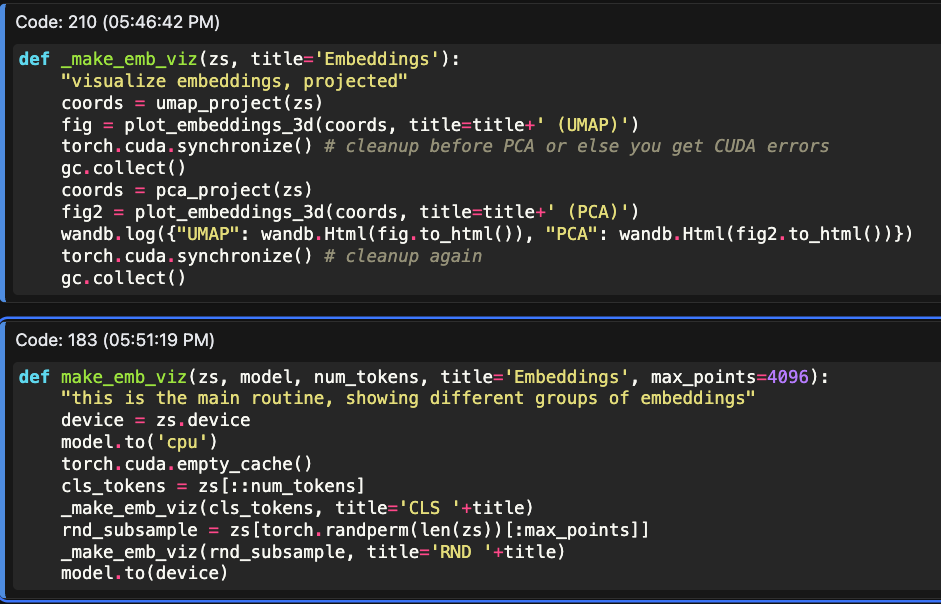


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You're right — both calls use the same keys "UMAP" and "PCA". Just include the title in the wandb keys:

```python
wandb.log({f"{title} UMAP": wandb.Html(fig.to_html()), f"{title} PCA": wandb.Html(fig2.to_html())})
```

That'll give you "CLS Embeddings UMAP", "RND Embeddings UMAP", etc.

Oh, drat. The way I'm passing in the title, it was including the epoch number in a really nice way: 
```
make_emb_viz(torch.cat((z1, z2), dim=0), model, num_tokens, title=f'Embeddings, epoch={epoch}')
```
But now that means that the 1B title is different every time. It's gonna make a gigantic number of plots. Uh I guess what I'll do is j I'll just pass in the epoch number separately.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yep, pass `epoch` separately, then use it in the plot title but not in the wandb key:

```python
def _make_emb_viz(zs, title='Embeddings', epoch=None):
    plot_title = f"{title}, epoch={epoch}" if epoch else title
    # ... use plot_title for the figure title
    wandb.log({f"{title} UMAP": ..., f"{title} PCA": ...})  # title without epoch
```

That way wandb keys stay consistent and the plots update in place.

Okay, I'm getting a bunch of complaints from Wand B about the stepping?
```
Epoch 9/1000:   3%|▎         | 5/185 [00:03<01:29,  2.00it/s]wandb: WARNING Tried to log to step 8 that is less than the current step 15. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Epoch 9/1000: 100%|██████████| 185/185 [01:16<00:00,  2.43it/s]
Epoch 9/1000: train_loss=6.483 val_loss=6.015
curr_learn: max_shift_x = 2, max_shift_y = 2
Epoch 10/1000:   1%|          | 2/185 [00:01<02:21,  1.29it/s]wandb: WARNING Tried to log to step 9 that is less than the current step 17. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Epoch 10/1000: 100%|██████████| 185/185 [01:16<00:00,  2.43it/s]
Epoch 10/1000: train_loss=6.421 val_loss=4.689
Saving checkpoint to checkpoints/ckpt_epoch10.pt
wandb: WARNING Tried to log to step 10 that is less than the current step 19. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
```
Can you re-scrape the train script and the viz script and look for any issues with the wandb step stuff? I think it's probably because we were doing step equals epoch, but I'm not sure. In theory, all this stuff should be on the same step, but 1b can be a little finicky. It kinda wants to increment the step every time you call 1b.log, which I think is stupid, but I've had issues in the past.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>view(path='midi_rae/train.py')</summary>

```json
{
  "id": "toolu_014f2cvzHnJrk4aCwN7JtHUU",
  "call": {
    "function": "view",
    "arguments": {
      "path": "midi_rae/train.py"
    }
  },
  "result": "'\"\"\"Training script for midi_rae\"\"\"\\n\\n# AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/06_train.ipynb.\\n\\n# %% auto #0\\n__all__ = [\\'curr_learn\\', \\'train\\']\\n\\n# %% ../nbs/06_train.ipynb #98edfbef\\nimport os\\nimport torch\\nimport torch.nn as nn\\nfrom torch.utils.data import DataLoader\\nimport wandb\\nfrom hydra import compose, initialize\\nfrom omegaconf import DictConfig, OmegaConf\\nimport hydra\\nfrom .encoder import ViT\\nfrom .data import PRPairDataset\\nfrom .lejepa import LeJEPA\\nfrom .utils import save_checkpoint\\nfrom .viz import make_emb_viz\\nfrom tqdm.auto import tqdm\\nimport multipro<TRUNCATED>"
}
```

</details>



<details class='tool-usage-details'>
<summary>view(path='midi_rae/viz.py')</summary>

```json
{
  "id": "toolu_01N9q57stbdG8KBZ6XknDXwy",
  "call": {
    "function": "view",
    "arguments": {
      "path": "midi_rae/viz.py"
    }
  },
  "result": "'\"\"\"vizualization routines\"\"\"\\n\\n# AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/05_viz.ipynb.\\n\\n# %% auto #0\\n__all__ = [\\'cpu_umap_project\\', \\'cuml_umap_project\\', \\'umap_project\\', \\'cuml_pca_project\\', \\'cpu_pca_project\\', \\'pca_project\\',\\n           \\'plot_embeddings_3d\\', \\'make_emb_viz\\']\\n\\n# %% ../nbs/05_viz.ipynb #b96051a7\\nimport torch\\nimport numpy as np\\nimport wandb\\nimport gc\\n\\n# %% ../nbs/05_viz.ipynb #a164c279\\ndef cpu_umap_project(embeddings, n_components=3, n_neighbors=15, min_dist=0.1, random_state=42):\\n    \"Project embeddings to n_components dimensions via UMAP (on<TRUNCATED>"
}
```

</details>

The issue: in `viz.py`, your `wandb.log()` calls don't specify a `step`, so wandb auto-increments. Then back in `train.py` you log with `step=epoch`, but wandb's internal step counter is now ahead.

Two options:

1. **Add `step=epoch` to the viz logs too** — pass `epoch` and use it:
   ```python
   wandb.log({...}, step=epoch)
   ```

2. **Remove `step=epoch` everywhere** and let wandb manage steps automatically (just log everything together in one `wandb.log()` call per epoch).

Option 2 is cleaner — you could collect all the viz figures and return them from `make_emb_viz`, then log everything in one call in `train.py`. But option 1 is a quicker fix.

Which do you prefer?

Oh. So I just add step equals epac to that one line in the viz thing:
`    wandb.log({f"{title} UMAP": wandb.Html(fig.to_html()), f"{title} PCA": wandb.Html(fig2.to_html())}, step=epoch)`

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yep, that's it. Just make sure `epoch` is passed down through `make_emb_viz` → `_make_emb_viz` so it's available there.

...Alright, we'll just let this encoder train for a while now while we do other things.

# Decoder

Okay, next up we need to start building the decoder code.  So we'll need a notebook for the architecture, `nbs/07_decoder.ipynb` 
And we can start to try to figure out what sort of architecture should we use for the decoder?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

I'll create the notebook for you:

<details class='tool-usage-details'>
<summary>create(path='nbs/07_decoder.ipynb', file_text='{\n "cells": [\n  {\n   "cell_type": "markdown",\n   "…')</summary>

```json
{
  "id": "toolu_01GAFq7xAFz6xi4uNb8TtzhL",
  "call": {
    "function": "create",
    "arguments": {
      "path": "nbs/07_decoder.ipynb",
      "file_text": "{\n \"cells\": [\n  {\n   \"cell_type\": \"markdown\",\n   \"metadata\": {},\n   \"source\": [\"# Decoder\\n\", \"\\n\", \"> Decoder architecture for reconstructing images from encoder representations\"]\n  },\n  {\n   \"cell_type\": \"code\",\n   \"execution_count\": null,\n   \"metadata\": {},\n   \"outputs\": [],\n   \"source\": [\"#| default_exp decoder\"]\n  }\n ],\n \"metadata\": {\n  \"kernelspec\": {\n   \"display_name\": \"python3\",\n   \"language\": \"python\",\n   \"name\": \"python3\"\n  }\n },\n \"nbformat\": 4,\n \"nbformat_minor\": 4\n}"
    }
  },
  "result": "'Created file /app/data/midi-rae/nbs/07_decoder.ipynb.'"
}
```

</details>

For the decoder architecture, the main options are:

1. **Simple ConvTranspose stack** — progressively upsample from the 8×8 patch grid to 128×128
2. **ViT-style decoder** — transformer blocks followed by a patch "unprojection"
3. **Lightweight CNN** — what the RAE paper actually uses (they found heavy decoders unnecessary)

Given your 8×8 grid of 768-d patch tokens → 128×128 × 1 output, which direction appeals to you?

What did they use in the RAE paper? If you need to refresh your context, it's here: https://arxiv.org/html/2510.11690v1


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>read_url(url='https://arxiv.org/html/2510.11690v1', selector='section')</summary>

```json
{
  "id": "toolu_01Xi137p2jGR9zbANKqer4is",
  "call": {
    "function": "read_url",
    "arguments": {
      "url": "https://arxiv.org/html/2510.11690v1",
      "selector": "section"
    }
  },
  "result": "'##  1 Introduction\\n\\nThe evolution of generative modeling has been driven by a continual redefinition of _where_ and _how_ models learn to represent data. Early pixel-space models sought to directly capture image statistics, but the emergence of latent diffusion (Vahdat et al., [2021](https://arxiv.org/html/2510.11690v1#bib.bib86); Rombach et al., [2022](https://arxiv.org/html/2510.11690v1#bib.bib71)) reframed generation as a process operating within a learned, compact representation space. By diffusing in this space rather than in raw pixels, models such as Latent Diffusion Models (LDM) (Ro<TRUNCATED>"
}
```

</details>

From the RAE paper, the key points about their **decoder architecture**:

1. **ViT-based decoder** — They use a Vision Transformer decoder (ViT-B, ViT-L, or ViT-XL), not a convolutional decoder
2. **Loss function**: L1 + LPIPS + adversarial (GAN) loss with adaptive weighting
3. **Noise-augmented training**: They add noise to the encoder outputs during decoder training to make it more robust to imperfect diffusion outputs
4. **Discriminator**: Frozen DINO-S/8 as the discriminator for the GAN loss

For your setup with 8×8 patches of 768-d tokens (128×128 images with 16×16 patch size), a ViT decoder would:
- Take the 64 patch tokens (8×8 grid) + learnable CLS token
- Process through transformer blocks
- "Unpatchify" back to 128×128 pixels

Does a ViT decoder sound like the right direction for your project, or would you prefer something simpler to start (like just L1 loss without GAN)?

Interesting. So earlier 02_encoder.ipynb was called 02_vit.ipynb But that was back when I was only using when I was only writing the encoder. And I figured I probably wouldn't be using the same architecture for the decoder.  But perhaps some of that can be reused??  It's still the case that the only thing in the encoder file is the v definition of the VIT class.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yes, a lot can be reused! The core transformer components — `RoPE2D`, `Attention`, `TransformerBlock` — work in both directions. 

The main differences for a ViT decoder:
- **Input**: patch tokens instead of an image
- **Output**: "unpatchify" layer instead of `PatchEmbedding` — basically the inverse operation

You could either:
1. Import those classes from `encoder.py` into `decoder.py`
2. Factor them out into a shared `vit_components.py` or `transformer.py`

Which approach feels cleaner to you?

Well, you know, honestly, there's not that much code to it. We could put both the encoder and the decoder into the same file. We could rename 02_encoder back to 02_vit, delete 07_decoder, and then within 02_vit, we'll have an Encoder class and a Decoder class. Don't actually make those changes yourself. I'll do them. But what do you think?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Makes sense — they share the same building blocks (`PatchEmbedding`, `Attention`, `TransformerBlock`, `RoPE2D`), so keeping them together avoids import complexity and makes the relationship clear. Clean approach.

Yeah, and then I don't have to worry about importing stuff back and forth

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Exactly. Let me know once you've renamed things, and we can sketch out the Decoder class structure together.

Ok if you take a look at `midi_rae/vit.py` you'll see the stub for a `ViTDecoder` class. All I did was I took the encoder class and sort of gutted it. But I don't really know how the decoder should work. Seems like..... yeah help me out?  I don't mean help me out as in just write it for me. I mean what is the actual process that it's gonna be doing? We probably need to write some more blocks for it.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>view(path='midi_rae/vit.py')</summary>

```json
{
  "id": "toolu_01WAntXb9msTFVDW8bhUfXjX",
  "call": {
    "function": "view",
    "arguments": {
      "path": "midi_rae/vit.py"
    }
  },
  "result": "'\"\"\"Components & defs for ViT-based Encoder & Decoder\"\"\"\\n\\n# AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/02_vit.ipynb.\\n\\n# %% auto #0\\n__all__ = [\\'PatchEmbedding\\', \\'RoPE2D\\', \\'Attention\\', \\'TransformerBlock\\', \\'ViTEncoder\\', \\'ViTDecoder\\']\\n\\n# %% ../nbs/02_vit.ipynb #b96051a7\\nimport torch\\nimport torch.nn as nn\\nimport torch.nn.functional as F \\n\\n# %% ../nbs/02_vit.ipynb #a164c279\\nclass PatchEmbedding(nn.Module):\\n    def __init__(self, \\n                in_channels=1,  # 1 for solo piano, for midi PR\\'s, = # of instruments\\n                patch_size=16,  # assuming square p<TRUNCATED>"
}
```

</details>

Good — I see your stub. Let me walk you through the decoder's job conceptually:

**Encoder flow** (what you have):
```
Image (B, 1, 128, 128) → PatchEmbedding → (B, 64, 768) → add CLS → TransformerBlocks → (B, 65, 768)
```

**Decoder flow** (inverse):
```
(B, 65, 768) → TransformerBlocks → (B, 64, 768) [drop CLS] → "Unpatchify" → Image (B, 1, 128, 128)
```

The new component you need is the **unpatchify** step — the inverse of `PatchEmbedding`. It takes each 768-d patch token and expands it back to a 16×16 pixel patch, then stitches them into the full image.

Does that make sense so far? If so, want to think about how to implement the unpatchify operation?

Okay. So are we going to do some kind of conv transpose two D type thing or just a linear layer? Or what do you think for that?
I don't really know what I'm doing here.
```python
class Unpatchify(nn.Module):
    def __init__(self, 
                out_channels=1,  # 1 for solo piano, for midi PR's, = # of instruments
                image_size = (128, 128)  # h,w for output image  
                patch_size=16,  # assuming square patches, e.g. 16 implies 16x16
                dim=768):       # embedding dimension
        super().__init__()
        self.conv = nn.ConvTranspose2d(dim, out_channels, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):  # x: (batch, num_patches, dim)
        #assert all(s % self.conv.kernel_size[0] == 0 for s in x.shape[-2:]), \
        #    f"Image size {x.shape[-2:]} must be divisible by patch_size {self.conv.kernel_size[0]}"
        #return self.conv(x).flatten(2).permute(0,2,1)         
        return out # (B, out_channels, H, W) 
```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Two common approaches:

1. **Linear projection**: Each 768-d token → `patch_size * patch_size * out_channels` values via a linear layer, then reshape
2. **ConvTranspose2d**: First reshape tokens into a spatial grid, then upsample

The linear approach is what MAE (Masked Autoencoder) uses — it's simpler. The key insight: each patch token just needs to become a 16×16 pixel block.

For the linear approach, the forward pass would be:
1. Project: `(B, 64, 768)` → `(B, 64, 256)` where 256 = 16×16×1
2. Reshape to `(B, 8, 8, 16, 16, 1)` 
3. Rearrange to `(B, 1, 128, 128)`

Does that make sense? Want to try implementing it that way?

Okay, I'll try the linear version that you suggest:
```python
class Unpatchify(nn.Module):
    def __init__(self, 
                out_channels=1,  # 1 for solo piano, for midi PR's, = # of instruments
                image_size = (128, 128),  # h,w for output image  
                patch_size=16,  # assuming square patches, e.g. 16 implies 16x16
                dim=768):       # embedding dimension
        super().__init__()
        self.image_size, self.patch_size, self.out_channels = image_size, patch_size, out_channels
        self.npatches_x, self.npatches_y = image_size[0]//patch_size, image_size[1]//patch_size 
        self.lin = nn.Linear(dim, out_channels * patch_size * patch_size )  # (B, 64, 768) -> (B, 64, 256) 
        
    def forward(self, z):  # z: patch embeddings (batch, num_patches, dim)
        out = self.lin(z)  # B, N, D 
        out = out.reshape(-1, self.npatches_x, self.npatches_y, self.patch_size, self.patch_size, self.out_channels)
        out = out.permute(0, 5, 1, 3, 2, 4)  # (B, 1, 8, 16, 8, 16)
        out = out.reshape(-1, self.out_channels, self.image_size[0], self.image_size[1])        
        return out # (B, out_channels, H, W) 
```
eh?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Looks correct! The permute puts dimensions in the right order so that `(npatches_x, patch_size)` and `(npatches_y, patch_size)` are adjacent before the final reshape.

Want to write a quick test to verify the shapes work end-to-end?

```python
z = torch.randn([3, 64, 768]) 
unpatch = Unpatchify() # keep the defaults
img = unpatch(z) 
print("img.shape = ",img.shape)
```
Output: 
```
img.shape =  torch.Size([3, 1, 128, 128])
```

Yea? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Perfect! Shapes check out. Now you can wire up the full `ViTDecoder` class — it needs:

1. Transformer blocks (reuse `TransformerBlock`)
2. Drop the CLS token (or don't include it)
3. `Unpatchify` at the end

What should the input to the decoder be — all 65 tokens including CLS, or just the 64 patch tokens?

```python
class ViTDecoder(nn.Module):
    """Vision Transformer Decoder for piano rolls"""
    def __init__(self, 
                out_channels,  # 
                image_size,   # tuple (H,W), e.g. (256, 256)
                patch_size,   # assuming square patches, e.g 16
                dim,          # embedding dim, e.g. 768
                depth=4,        # number of transformerblock layers -- 4? 
                heads=8):       # number of attention heads - 8? 
        super().__init__()
        self.blocks = nn.ModuleList([ TransformerBlock(dim, heads) for _ in range(depth) ])
        self.unpatch = Unpatchify(out_channels, image_size, patch_size, dim)
        
    def forward(self, z, strip_cls_token=True):
        for block in self.blocks:  z = block(z)
        if strip_cls_token: z = z[:,1:] 
        img = self.unpatch(z) 
        return img
```
How's that?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Looks good! Clean and simple.

One consideration: your `TransformerBlock` uses `RoPE2D` for positional info. That should still work here since the patch tokens maintain their grid order. Just make sure the decoder gets the same `(h, w)` grid dimensions that RoPE2D expects.

Want to test it end-to-end with a random input?

Uh I'm not sure what you're talking about with the rope stuff. I'm gonna do the same thing with the decoder that I did with the encoder or?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yes, same thing — the `TransformerBlock` already handles RoPE internally. It should just work.

Try testing it:
```python
z = torch.randn(3, 65, 768)  # batch of 3, with CLS token
decoder = ViTDecoder(out_channels=1, image_size=(128,128), patch_size=16, dim=768)
img = decoder(z)
print(img.shape)
```

torch.Size([3, 1, 128, 128])

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠

Decoder works. Now you'll need:

1. **Training loop** for the decoder (freeze encoder, train decoder on reconstruction)
2. **Loss function** — start simple with L1/MSE, or go straight to L1 + LPIPS + GAN like RAE?

Which do you want to tackle first?

So, this implies we're going to be adding some more losses. Do we actually need to write much code for that? If so, I should probably put that in the same file as the Led Jepa stuff, and then I could rename the file `lejepa.py` to `losses.py` ?  But if it's really just as simple as importing LPIPS and GAN from PyTorch, then maybe I don't need to bother with that.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

LPIPS isn't in PyTorch — it's a separate package (`pip install lpips`), but usage is simple: `lpips.LPIPS(net='vgg')` gives you a callable loss.

GAN loss requires more work — you need a discriminator network. RAE uses frozen DINO-S/8 as theirs.

So: LPIPS is easy, GAN needs custom code. You could start with just L1 + LPIPS to get things working, then add the adversarial component later. Worth renaming to `losses.py` if you're going to add more there?

Interesting question, where should the GAN go in terms of the code base? Should it go in its own file? Or should it be considered part of the losses?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

The discriminator is a neural network, so architecturally it's more like `vit.py` than a loss function. But the adversarial loss computation itself is just a loss.

Options:
1. **Discriminator in `vit.py`** — keeps all neural network architectures together
2. **Discriminator in its own `discriminator.py`** — separate since it's only used for training, not inference
3. **Both discriminator + adversarial loss in `gan.py`** — self-contained GAN module

What feels cleanest to you?

Oh, well then we wouldn't want it to be called VIT unless the discriminator itself is actually a VIT..... Oh right. The discriminator is just a classifier. We could make a VIT classifier. Or is that overkill? Should we just use some kind of simple conv two D type thing if all it has to do is measure yes or no?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

RAE uses a frozen pretrained DINO-S/8 — they don't train the discriminator at all. That's appealing because it's one less thing to train.

But for your MIDI piano rolls (OOD images), a pretrained DINO might not give meaningful features. A small PatchGAN-style ConvNet (a few conv layers → real/fake output) is simple and trains fast.

Which sounds more appropriate for your domain?

Right, definitely we're always going to be out of distribution for any pre-trained anything. We're gonna have to roll our own.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

A simple PatchGAN discriminator then — just a few Conv2d layers that output a grid of real/fake predictions rather than a single value. It's what pix2pix uses and it's lightweight.

Want to put it in its own `discriminator.py`, or bundle it with the GAN loss in a `gan.py`?

Right, we could rename vit.py to models.py,  But we also have to consider that we're going to be making the diffusion transformer too. And I think it's gonna get a little messed up if we try and pack every single neural anything into one file

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good point. Separate files makes sense:
- `vit.py` — encoder + decoder (they share components)
- `discriminator.py` — PatchGAN for decoder training
- `dit.py` — diffusion transformer (later)

That keeps each file focused. Sound reasonable?

Okay, sounds good.  and then, in that case we're not renaming the Legepa stuff to losses.?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Right — LeJEPA is specific to encoder training, while L1/LPIPS/GAN are for decoder training. They're pretty separate.

You could keep `lejepa.py` as-is, and just put the GAN loss alongside the discriminator in `discriminator.py`. LPIPS is just a one-liner import anyway.

Okay, and then if I have a bunch of different files, I don't necessarily to have to do a whole long line of import statements at the top of the script.  Although I guess doing so would be the fastest as it targets exactly what we need. 
the alternative is we "import midi_rae as mr" and then do "mr.xxxx" for everything. hmmmm

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Either works. The `import midi_rae as mr` approach is cleaner and makes it obvious where things come from (`mr.ViTEncoder`, `mr.ViTDecoder`, etc.). Just make sure your `__init__.py` exports everything you need.

The explicit imports are marginally faster but it's negligible for training scripts. Personal preference mostly.

Tell you what, that kind of refactoring shit is something that LLMs are perfectly suited for. So we'll table that, and then we'll do a big refactor later. First we'll
we'll make a `nbs/07_discriminator.ipynb`, and we'll make  a `08_train_dec.ipynb`  (later we'll rename `06_train.ipynb` to `06_train_enc.ipynb`, And even later, we can make a `09_dit` and a `10_train_gen`). Does this sound like a reasonable plan?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Sounds like a solid plan. Clear separation of concerns:
- `07_discriminator.ipynb` — PatchGAN discriminator
- `08_train_dec.ipynb` — decoder training (L1 + LPIPS + GAN)
- Later: `09_dit.ipynb`, `10_train_gen.ipynb`

Which do you want to start with — the discriminator or the training loop?

Tell you what How about if you generate a dummy NB Dev notebook for `nbs/07_discriminator.ipynb`, And then I'll go in there and start to write it. And since there's a dialogue there, I can use an LLM and a dedicated chat for that-- Oh, tell you what, when you fill in the dummy, why don't you add a note that explains to the other LLM what we're doing and why and what some of the parameters will be?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>create(path='nbs/07_discriminator.ipynb', file_text='{\n "cells": [\n  {\n   "cell_type": "markdown",\n   "…')</summary>

```json
{
  "id": "toolu_013iUsUqGV7qyZPD1X6DwQ1q",
  "call": {
    "function": "create",
    "arguments": {
      "path": "nbs/07_discriminator.ipynb",
      "file_text": "{\n \"cells\": [\n  {\n   \"cell_type\": \"markdown\",\n   \"metadata\": {},\n   \"source\": [\"# Discriminator\\n\", \"\\n\", \"> PatchGAN discriminator for decoder training\"]\n  },\n  {\n   \"cell_type\": \"markdown\",\n   \"metadata\": {},\n   \"source\": [\"## Context for LLM assistance\\n\", \"\\n\", \"This project implements a Representation Autoencoder (RAE) for MIDI piano roll images.\\n\", \"\\n\", \"**Architecture overview:**\\n\", \"- **Encoder**: ViT that produces 64 patch tokens (8\u00d78 grid) + 1 CLS token, each 768-d\\n\", \"- **Decoder**: ViT-style decoder with `Unpatchify` layer that reconstructs 128\u00d7128 grayscale images\\n\", \"- **Dis<TRUNCATED>"
    }
  },
  "result": "'Created file /app/data/midi-rae/nbs/07_discriminator.ipynb.'"
}
```

</details>

Done! The notebook has a context section explaining the project, image specs, and discriminator requirements for the other LLM to pick up from.

Hang on a second. The patch discriminator is just a very short amount of code: 
```python
class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_ch=1, base_ch=64, n_layers=3, use_spectral_norm=True):
        super().__init__()
        norm = nn.utils.spectral_norm if use_spectral_norm else (lambda x: x)
        layers = [norm(nn.Conv2d(in_ch, base_ch, kernel_size=4, stride=2, padding=1)), nn.LeakyReLU(0.2, True)]
        ch = base_ch
        for i in range(1, n_layers):
            ch_next = min(ch * 2, 512)  # double channels each layer, but cap at 512 to limit params
            layers += [norm(nn.Conv2d(ch, ch_next, kernel_size=4, stride=2, padding=1)), nn.LeakyReLU(0.2, True)]
            ch = ch_next
        layers.append(norm(nn.Conv2d(ch, 1, kernel_size=4, stride=1, padding=1)))
        self.net = nn.Sequential(*layers)

    def forward(self, x): return self.net(x)
```
Like I don't see any point having that all by itself in its own file.
Since it is kind of related to a loss function, then maybe what I will do is yeah, rename the Le Jeppa thing to losses, and then I'll stick this in there. Does that sound good? I'm not asking you to change anything. I'll do it manually

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yeah, that makes sense — it's only ~15 lines. Bundling it with other loss-related code in `losses.py` is cleaner than a whole separate file. Go for it.

In [ ]:
# new file structure
!ls midi_rae/*.py

midi_rae/__init__.py  midi_rae/data.py	     midi_rae/utils.py
midi_rae/_modidx.py   midi_rae/losses.py     midi_rae/vit.py
midi_rae/core.py      midi_rae/train_enc.py  midi_rae/viz.py


In [ ]:
!ls nbs/*.ipynb

nbs/00_core.ipynb  nbs/03_losses.ipynb	nbs/06_train_enc.ipynb
nbs/01_data.ipynb  nbs/04_utils.ipynb	nbs/index.ipynb
nbs/02_vit.ipynb   nbs/05_viz.ipynb


Okay, so that's what the project looks like now. By the way, core isn't being used for anything and I'll eventually just delete it.
I fixed up the train_enc script so that it's importing from the proper places now.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Clean structure! Ready to start on `08_train_dec.ipynb` when you are.

### Pre-Encoding Data

Okay, interesting thing on the naming and whatnot. We could in theory pre-encode a bunch of frozen data embeddings. That way, when we're training the decoder we could save some time not having to encode it each time. In the stable diffusion 3 paper, they mention pre-encoding a lot of their data. What do you think? If we did that, then the next script to write would be... `07_preencode` Or something like that.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good idea — since the encoder is frozen during decoder training, pre-encoding saves redundant forward passes every epoch.

Tradeoffs:
- **Pro**: Faster decoder training, simpler training loop
- **Con**: Disk space (though 65 × 768 × 4 bytes ≈ 200KB per image is likely smaller than the images themselves)

One consideration: you'll want to re-encode whenever you get a better encoder checkpoint. But that's a one-time cost per checkpoint.

`07_preencode.ipynb` sounds right. Want to sketch that out?

Yeah, I think what I'll do is when we Write the decoder training script, We'll (somehow) give it the option to either use pre-encoded data or to encode on the fly. Maybe via some kind of command line argument

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Makes sense. A simple flag like `--preencoded` (or in Hydra config: `data.preencoded: true/false`) could switch between:
- Loading `.pt` files of embeddings
- Loading images and running them through the frozen encoder

The Dataset class would handle the difference — either returning `(z, img)` tuples from disk or computing `z` on the fly.

Want to start with `07_preencode.ipynb` first, or go straight to `08_train_dec.ipynb` and do on-the-fly encoding initially?

Oh, and I think the checkpoints that we've been saving for the encoder are just named something really generic: 
```
$ ls checkpoints/
best.pt  ckpt_epoch30.pt  ckpt_epoch40.pt  ckpt_epoch50.pt  ckpt_epoch60.pt  ckpt_epoch70.pt
```
Okay, let's establish for now that unless otherwise noted those will be encoded or checkpoints, and then we'll have `dec_ckpt_40.pt` etc for decoder checkpoints, and maybe `gen_ckpt_40.pt` for dit checkpoints. (or maybe even `dit_ckpt_40.pt`).  That way, I don't have to bother with renaming checkpoint files from the encoder and stuff. How does that sound

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Sounds good — simple and backwards-compatible with what you already have. `dit_ckpt_` is probably clearer than `gen_ckpt_` since "gen" is vague.

ok, so is `07_preencode.ipynb` a sutable name for the (optional) pre-encoding script? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠

Yep, `07_preencode.ipynb` works well. It fits the numbering (after losses, before decoder training) and the name is self-explanatory.

Alright. I think you get the idea here. take a look at `midi-rae/train_enc.py`, And set up for me a `nbs/07_preencode.ipynb` file. We're going to read from a config file that probably is the same as the other one. We'll just have a You know, any little parts will `preencode:` A lot of it's going to look the same, you know. We're going to load the model from a checkpoint that will specify with a CLI arg. We're going to run through a bunch of data. We're going to save it somehow in a fairly efficient manner probably chunked up and save it to some directory that could also be specified. Actually, we can put that in the config file, the destination, maybe. I don't know.  Can you mock up a pre-encoding notebook file with what you think needs to go in there, and then I'll go in there and fix it up myself? But you can get me started most of the way, I think.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>view(path='midi_rae/train_enc.py')</summary>

```json
{
  "id": "toolu_01Fm2TUyHsvubqzhHyaVxxcb",
  "call": {
    "function": "view",
    "arguments": {
      "path": "midi_rae/train_enc.py"
    }
  },
  "result": "'\"\"\"Encoder training script for midi_rae\"\"\"\\n\\n# AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/06_train_enc.ipynb.\\n\\n# %% auto #0\\n__all__ = [\\'curr_learn\\', \\'compute_batch_loss\\', \\'train\\']\\n\\n# %% ../nbs/06_train_enc.ipynb #98edfbef\\nimport os\\nimport torch\\nimport torch.nn as nn\\nfrom torch.utils.data import DataLoader\\nimport wandb\\nfrom hydra import compose, initialize\\nfrom omegaconf import DictConfig, OmegaConf\\nimport hydra\\nfrom .vit import ViTEncoder\\nfrom .data import PRPairDataset\\nfrom .losses import LeJEPA\\nfrom .utils import save_checkpoint\\nfrom .viz import make_emb_viz\\n<TRUNCATED>"
}
```

</details>



<details class='tool-usage-details'>
<summary>view(path='configs/config.yaml')</summary>

```json
{
  "id": "toolu_01SMtCMQg6dQD77rEducJhue",
  "call": {
    "function": "view",
    "arguments": {
      "path": "configs/config.yaml"
    }
  },
  "result": "'data:\\n  path: /home/shawley/datasets/POP909_images  # adjust path as needed\\n  image_size: 128\\n  in_channels: 1\\n\\nmodel:\\n  patch_size: 16\\n  dim: 768\\n  depth: 4\\n  heads: 8\\n\\ntraining:\\n  batch_size: 440\\n  lr: 1e-3\\n  epochs: 1000\\n  lambd: 0.3\\n  max_shift_x: 1   # will increase w/epoch via curriculum\\n  max_shift_y: 1\\n\\nwandb:\\n  project: vit-midi-rae\\n\\n'"
}
```

</details>



<details class='tool-usage-details'>
<summary>create(path='nbs/07_preencode.ipynb', file_text='{\n "cells": [\n  {\n   "cell_type": "markdown",\n   "…')</summary>

```json
{
  "id": "toolu_0175pkmFGGXKKm2kovyBb1rT",
  "call": {
    "function": "create",
    "arguments": {
      "path": "nbs/07_preencode.ipynb",
      "file_text": "{\n \"cells\": [\n  {\n   \"cell_type\": \"markdown\",\n   \"metadata\": {},\n   \"source\": [\"# Pre-encode\\n\", \"\\n\", \"> Pre-encode images using frozen encoder for faster decoder training\"]\n  },\n  {\n   \"cell_type\": \"code\",\n   \"execution_count\": null,\n   \"metadata\": {},\n   \"outputs\": [],\n   \"source\": [\"#| default_exp preencode\"]\n  },\n  {\n   \"cell_type\": \"code\",\n   \"execution_count\": null,\n   \"metadata\": {},\n   \"outputs\": [],\n   \"source\": [\"#| export\\n\", \"import os\\n\", \"import torch\\n\", \"from torch.utils.data import DataLoader\\n\", \"from omegaconf import DictConfig, OmegaConf\\n\", \"import hydra\\n\", \"from tqdm.au<TRUNCATED>"
    }
  },
  "result": "'Created file /app/data/midi-rae/nbs/07_preencode.ipynb.'"
}
```

</details>

Done! The notebook includes:
- Loading encoder from a checkpoint (CLI arg: `encoder_ckpt=...`)
- Processing train/val splits
- Saving embeddings + original images (for reconstruction loss) as `.pt` files
- A TODO note about potentially needing a simpler single-image dataset

You'll probably want to tweak the dataset usage and decide whether chunked saves make more sense for your data size. Take a look and refine as needed!

Great. And how about if you modify the config file to make it compatible with this script? Or maybe you didn't actually need any new variables from the config file. If it's all CLI ARGs, that's fine.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

I added a `preencode:` section in the script that expects `output_dir` and `chunk_size`. Let me add that to the config:

<details class='tool-usage-details'>
<summary>str_replace(path='configs/config.yaml', old_str='wandb:\n  project: vit-midi-rae', new_str='preencode:\n  output_dir: /home/shawley/datasets/PO…')</summary>

```json
{
  "id": "toolu_01UXjnSXVKjsBrUqBHKLb2nq",
  "call": {
    "function": "str_replace",
    "arguments": {
      "path": "configs/config.yaml",
      "old_str": "wandb:\n  project: vit-midi-rae",
      "new_str": "preencode:\n  output_dir: /home/shawley/datasets/POP909_encoded\n  chunk_size: 1000  # images per .pt file\n\nwandb:\n  project: vit-midi-rae"
    }
  },
  "result": "'Replaced text in /app/data/midi-rae/configs/config.yaml'"
}
```

</details>

Done! Added `preencode.output_dir` and `preencode.chunk_size` to the config. The encoder checkpoint path stays as a CLI arg since you'll likely vary that more often.

Oh good call hanging on to the um original images too because we can't just use the file names of the original images since we cropped them.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Exactly — the random crops mean each embedding corresponds to a unique view that can't be reproduced from the source file. Saving them together keeps everything aligned for the reconstruction training.

## Back to the Decoder

Okay, whether we pre-encode or not we will need to make a `08_train_dec` notebook. How about if you set that up using your best guesses at some boilerplate, put a note in explaining to the next LLM chat what we've been working on and what we're trying to do and where we're headed next, and then I'll pick it up from there and in that other chat in that notebook I can edit it and improve the training script. If you're confused about whether to use pre-encoded data or just load the encoder checkpoint and use that along with loading normal data of images, yeah, I don't want to make your job too hard. Maybe you could break some of that off into a sub function that's just called `get_embeddings_batch` Where it could do whatever it needs to do to either run images through the encoder or just load pre-encoded data. That way, the rest of your training script Doesn't need to have a lot of that logic in there. Just do the best you can, but don't worry about making it too long or too hard. I'll pick it up there later. Try and make it really concise though. Yep. Let's see what you can do.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>create(path='nbs/08_train_dec.ipynb', file_text='{\n "cells": [\n  {\n   "cell_type": "markdown",\n   "…')</summary>

```json
{
  "id": "toolu_0177i5ZgcGeESXEbyYkssTQ3",
  "call": {
    "function": "create",
    "arguments": {
      "path": "nbs/08_train_dec.ipynb",
      "file_text": "{\n \"cells\": [\n  {\n   \"cell_type\": \"markdown\",\n   \"metadata\": {},\n   \"source\": [\"# Train Decoder\\n\", \"\\n\", \"> Training script for the ViT decoder with reconstruction losses\"]\n  },\n  {\n   \"cell_type\": \"markdown\",\n   \"metadata\": {},\n   \"source\": [\"## Context for LLM assistance\\n\", \"\\n\", \"This is part of a Representation Autoencoder (RAE) project for MIDI piano roll images.\\n\", \"\\n\", \"**What we have:**\\n\", \"- `ViTEncoder` in `vit.py`: produces (B, 65, 768) \u2014 64 patch tokens + 1 CLS token from 128\u00d7128 images\\n\", \"- `ViTDecoder` in `vit.py`: takes (B, 65, 768), strips CLS, unpatchifies back to (B, 1<TRUNCATED>"
    }
  },
  "result": "'Created file /app/data/midi-rae/nbs/08_train_dec.ipynb.'"
}
```

</details>

Done! Key things in there:
- `PreEncodedDataset` class for loading pre-encoded `.pt` files
- `get_embeddings_batch()` helper that abstracts the data source
- Training loop with L1 + LPIPS + hinge GAN loss
- Frozen encoder when using on-the-fly encoding
- Context note at top explaining the whole pipeline for the next LLM

TODOs I left for you: adaptive loss weighting, validation loop, checkpointing, and visualization. Also the LPIPS `.repeat(1,3,1,1)` is a hack since LPIPS expects 3-channel input — you may want something cleaner.

Okay, I notice I didn't see any mention of this parameter you added: `cfg.model.get('dec_depth', 4)`. That's something I'm supposed to add to the config file?

```
cfg.model.get('dec_depth', 4), cfg.model.heads).to(device)
```
I don't mind defining that. Should we also make use of a `dec_heads` similarly? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yes, adding both makes sense — the decoder might want different depth/heads than the encoder. Add to your config:

```yaml
model:
  # ... existing encoder params ...
  dec_depth: 4
  dec_heads: 8
```

Or keep the `.get(..., default)` pattern if you want them optional with fallbacks to encoder values.

Org, I'm still running the encoder training script and we must have broken something. All the losses are a lot higher, even from the very beginning. I've just been refactoring without, in my opinion, changing anything of substance Not really doing anything to change the encoder training apart from renaming a few names. Certainly nothing that should affect the loss Where do you think we went wrong?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

The change from `return_cls_only=True` to `return_cls_only=False` is significant — you're now training 65 tokens instead of just 1 CLS token. Higher loss at the start is expected since those patch tokens were untrained before.

Is this a fresh run with the new patch-token setup, or did you expect it to continue from where the CLS-only training left off?

Oh, of course. Yes. This is a run with the patch token setup, so it's actually doing a lot more work than before. Okay. Yeah, apples vs oranges.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Exactly. The patch tokens are starting from scratch even if the CLS token had some training. Give it time — should come down as those 64 extra tokens per image learn meaningful representations.

Okay, one thing I've done is to increase the interval for increasing the difficulty of the curriculum learning From ten epochs to thirty epochs. Hopefully that'll give it a little more time on the easy problems -- For the first thirty epochs, there will only be a shift of one pixel, for example. I'm training for a thousand epochs, so by around epoch three sixty it will be at the hardest thing possible.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Makes sense — more time at each difficulty level should help the patch tokens converge better before the task gets harder. You can always adjust that interval later if training seems too slow or too fast.

Yeah, this is looking better. Previously, I was actually seeing two completely disjoint balls of embeddings....Actually, I wonder if that was only in the random subsampling.
Since we're already plotting the CLS embeddings by themselves, perhaps we should exclude them from the random subsample plotting.? What do you think?
Currently we have this: 

`rnd_subsample = zs[torch.randperm(len(zs))[:max_points]]`
The CLS token is the first one. So we could do something like....
`rnd_subsample = zs[1:][torch.randperm(len(zs-1))[:max_points]]`
...?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Close, but `zs[1:]` only removes the *first* CLS token. There's a CLS at every 65th position (0, 65, 130, ...).

Two options:

```python
# Option 1: boolean mask
patch_only = zs[torch.arange(len(zs)) % num_tokens != 0]

# Option 2: reshape and slice
patch_only = zs.reshape(-1, num_tokens, zs.shape[-1])[:, 1:].reshape(-1, zs.shape[-1])
```

Then subsample from `patch_only`. Which approach do you prefer?

like this? 
```
    patch_only = zs[torch.arange(len(zs)) % num_tokens != 0] # non-cls tokens 
    rnd_subsample = patch_only[torch.randperm(len(patch_only))[:max_points]]

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yep, that's correct!

Okay. I know that we don't even really need the CLS token since we're doing all the patches now. But, question: Is predicting CLS token somehow hurting us? Should we only do the patch tokens? Are we giving the model essentially two different training objectives now. Or maybe everything's okay.?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good question. With patches, CLS is being trained to produce a consistent global representation across crops, while patches learn local consistency. These aren't conflicting objectives — they're complementary.

However, one subtle issue: your delta-based attraction weighting treats CLS the same as patches, even though CLS represents the whole crop (barely affected by small shifts) while patches represent local regions (more affected).

Probably fine to keep CLS in — it's just one extra token out of 65. But if you want to simplify, dropping it would be cleaner. Your call.

Yeah, if the patches are sixteen pixels each and my maximum shift is twelve pixels, that's I mean, to me, maybe that's too much, and yet with the new schedule, even a shift of eight pixels won't happen until after two hundred epochs, so the first couple hundred epochs should be fine, or at least won't be fixed by any little changes I make.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Right — your curriculum protects you early on. By the time shifts get large enough to significantly affect patch alignment, the model will have had hundreds of epochs to build up decent representations.

Let it run and see how it looks around epoch 200-300 when shifts get bigger. You can revisit then if needed.

Okay, um so we're currently taking about 2.44 iterations per second. I wonder if there's anything we could do to speed it up. I mean, apart from decreasing the batch size...Which I might be okay with, but anything else speed-wise in our code that we could fix?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

A few common speedups to check:

1. **Mixed precision (AMP)** — `torch.autocast` + `GradScaler` can nearly double speed on a 4090
2. **`torch.compile(model)`** — PyTorch 2.0+ JIT, can give 10-30% boost
3. **DataLoader workers** — `num_workers=4` or higher, plus `pin_memory=True`
4. **`torch.backends.cudnn.benchmark = True`** — helps if input sizes are fixed

Are you using any of these already?

None workers is four. I don't know that the RTX 4090 Offers half precision natively, so I'm not sure if mixed precision would grant us any speed up. take a look at `midi-rae/train_enc.py` to confirm what's there and provide you with locations in the code where you might recommend to me adding speed up stuff.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>view(path='midi_rae/train_enc.py')</summary>

```json
{
  "id": "toolu_01Meb3vuwJ43sDKEmUsdErBv",
  "call": {
    "function": "view",
    "arguments": {
      "path": "midi_rae/train_enc.py"
    }
  },
  "result": "'\"\"\"Encoder training script for midi_rae\"\"\"\\n\\n# AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/06_train_enc.ipynb.\\n\\n# %% auto #0\\n__all__ = [\\'curr_learn\\', \\'compute_batch_loss\\', \\'train\\']\\n\\n# %% ../nbs/06_train_enc.ipynb #98edfbef\\nimport os\\nimport torch\\nimport torch.nn as nn\\nfrom torch.utils.data import DataLoader\\nimport wandb\\nfrom hydra import compose, initialize\\nfrom omegaconf import DictConfig, OmegaConf\\nimport hydra\\nfrom .vit import ViTEncoder\\nfrom .data import PRPairDataset\\nfrom .losses import LeJEPA\\nfrom .utils import save_checkpoint\\nfrom .viz import make_emb_viz\\n<TRUNCATED>"
}
```

</details>

You already have:
- `torch.backends.cudnn.benchmark = True` ✓
- `torch.compile(model)` ✓
- `num_workers=4` ✓

Missing:
- `pin_memory=True` in DataLoader — add this for faster CPU→GPU transfer

For AMP: the 4090 *does* support FP16/BF16 and gets significant speedups. You'd wrap the forward pass with `torch.autocast('cuda')` and use a `GradScaler`. Worth trying — could give you 30-50% speedup.

Want to add AMP?

I'm not sure what pin memory's really gonna accomplish since we're restarting the data loader every time. Would it?

How would we do the amp stuff? Is that already built in?


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

`pin_memory=True` helps per-batch — it uses page-locked memory for faster async transfer to GPU. Small win but free.

AMP is built into PyTorch:
```python
scaler = torch.cuda.amp.GradScaler()
with torch.autocast('cuda'):
    # forward pass here
scaler.scale(loss).backward()
scaler.step(optimizer)
scaler.update()
```

Want me to show where those pieces go in your training loop?

Yeah, I'm not really seeing it. is it just in this little part? 
```
            optimizer.zero_grad()
            loss, z1, z2, num_tokens = compute_batch_loss(batch, model, cfg, global_step)
            loss['loss'].backward()
            optimizer.step()
            train_loss += loss['loss'].item()
```
?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yes, that's the spot. You'd change it to:

```python
scaler = torch.cuda.amp.GradScaler()  # outside the loop, once

# then inside the batch loop:
optimizer.zero_grad()
with torch.autocast('cuda'):
    loss, z1, z2, num_tokens = compute_batch_loss(batch, model, cfg, global_step)
scaler.scale(loss['loss']).backward()
scaler.step(optimizer)
scaler.update()
train_loss += loss['loss'].item()
```

The `scaler` init goes near where you create the optimizer.

Okay, I think I did it. Can you re-scrape my training script? Also, let me know if I need to install anything new

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>view(path='midi_rae/train_enc.py')</summary>

```json
{
  "id": "toolu_01ANkZgpAB51XgsVpjPi82nU",
  "call": {
    "function": "view",
    "arguments": {
      "path": "midi_rae/train_enc.py"
    }
  },
  "result": "'\"\"\"Encoder training script for midi_rae\"\"\"\\n\\n# AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/06_train_enc.ipynb.\\n\\n# %% auto #0\\n__all__ = [\\'curr_learn\\', \\'compute_batch_loss\\', \\'train\\']\\n\\n# %% ../nbs/06_train_enc.ipynb #98edfbef\\nimport os\\nimport torch\\nimport torch.nn as nn\\nfrom torch.utils.data import DataLoader\\nimport wandb\\nfrom hydra import compose, initialize\\nfrom omegaconf import DictConfig, OmegaConf\\nimport hydra\\nfrom .vit import ViTEncoder\\nfrom .data import PRPairDataset\\nfrom .losses import LeJEPA\\nfrom .utils import save_checkpoint\\nfrom .viz import make_emb_viz\\n<TRUNCATED>"
}
```

</details>

Looks good! You've got:
- `scaler = torch.cuda.amp.GradScaler()` ✓
- `with torch.autocast('cuda'):` around the forward pass ✓
- `scaler.scale/step/update` ✓
- `pin_memory=True` ✓

No new installs needed — AMP is built into PyTorch.

Give it a test run and see if you get a speedup!

Okay, it's a little slow getting started because it's compiling, I think. But given that I'm going to run this for hours, it should be worth it.
... Okay, we went from 2.4 iterations per second to 6.3 iterations per second. 

Also got a warning: 
```
/home/shawley/github/midi-rae/.venv/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:321: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

2.6× speedup — nice!

For the warning, add this near the top of your script (with the other `torch.backends` stuff):

```python
torch.set_float32_matmul_precision('high')
```

Should squeeze out a bit more performance.

Okay, with just that one new line added, I now get...

```
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 168.00 MiB. GPU 0 has a total capacity of 23.54 GiB of which 112.19 MiB is free. Process 27350 has 17.47 GiB memory in use. Including non-PyTorch memory, this process has 5.86 GiB memory in use. Of the allocated memory 5.35 GiB is allocated by PyTorch, and 51.95 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

TF32 uses more memory than FP16. You were already at ~92% GPU usage — that pushed you over.

Either:
1. Remove that line and stick with the AMP speedup you already have
2. Lower batch size slightly (maybe 400 instead of 440)

I'd try option 1 first since 2.6× is already a solid win.

That's weird because I don't think we were ever using FP16 before so the change to TF32 I wouldn't think would add any new VRAM usage???

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You're right — TF32 shouldn't increase memory, it's the same tensor sizes. Might be a fluke with compilation or memory fragmentation on that run.

Try again? If it happens consistently, just drop the line — you've already got the big win from AMP.

I dropped the batch size to 400 instead of 440, but then it didn't feel like it was using enough VRAM. So splitting the difference, I put it on 420. Let's see if this runs. ...Yeah, we're only using sixty eight percent of the memory. Maybe that first execution was a fluke. Or maybe there's just a burst of RAM it tries to use. Let me put it back on 440

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Go for it. The OOM might have been from compilation overhead or fragmentation on that first run. If 440 works this time, you're golden.

Yeah, that was a fluke. 440's working. Um Still getting 6.3 iterations per second, so adding that extra line about the high precision didn't help or hurt. but hey a 2.6x speedup will enable me to experiment more quickly.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Excellent! 2.6× is a big win. Let it run and see how those patch embeddings evolve. Ready to pick up on decoder training whenever you are.

Okay, one other issue is that now the SIGREG loss is 10 times bigger than it used to be, but the SIM loss is not 10 times bigger. So rather than adjust lambda, I'm just going to change our fudge factor of /1000 for the sigreg loss to /10000 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Makes sense — you've got ~65× more tokens contributing to the SIGReg statistic, so it scales up. Adjusting the normalization factor is cleaner than changing lambda. Good call.

Oh yeah, that sigreg loss has a sum on the end of it. And we're multiplying by N. So this means the normalization's gonna change every time I change the batch size?

```
def SIGReg(x, global_step, num_slices=256):
    """SIGReg with Epps-Pulley statistic. x is (N, K) tensor."""
    device = x.device
    g = torch.Generator(device=device).manual_seed(global_step)
    proj_shape = (x.size(1), num_slices)
    A = torch.randn(proj_shape, generator=g, device=device)
    A = A / (A.norm(dim=0, keepdim=True) + 1e-10)  # normalize columns

    # Epps-Pulley statistic
    t = torch.linspace(-5, 5, 17, device=device) # values used in LeJEPA paper, worked for SSLtoy
    exp_f = torch.exp(-0.5 * t**2)  # theoretical CF for N(0,1)
    x_t = (x @ A).unsqueeze(2) * t  # (N, M, T)
    ecf = (torch.exp(1j * x_t).mean(dim=0)).abs()  # empirical CF
    diff = (ecf - exp_f).abs().square().mul(exp_f)  # weighted L2 distance
    N = x.size(0)
    T = torch.trapz(diff, t, dim=1).sum() * N
    return T
```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yes — that `* N` at the end means it scales with batch size. If you want it batch-invariant, you could divide by N instead (or remove the `* N` entirely).

What was the original intent of that multiplier?

Yeah, I can't actually find any mention of it in the LeJEPA paper. See if you can figure it out: https://arxiv.org/html/2511.08544v3

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>read_url(url='https://arxiv.org/html/2511.08544v3')</summary>

```json
{
  "id": "toolu_01PJF3QnczeF2xdq13xQRySR",
  "call": {
    "function": "read_url",
    "arguments": {
      "url": "https://arxiv.org/html/2511.08544v3"
    }
  },
  "result": "'1. [1 Introduction](https://arxiv.org/html/2511.08544v3#S1)\\n  2. [2 Background and Notations](https://arxiv.org/html/2511.08544v3#S2)\\n     1. [2.1 Notations and Definitions](https://arxiv.org/html/2511.08544v3#S2.SS1 \"In 2 Background and Notations\")\\n     2. [2.2 The Need for Reliable Pretraining](https://arxiv.org/html/2511.08544v3#S2.SS2 \"In 2 Background and Notations\")\\n     3. [2.3 The Need for Actionable Theory](https://arxiv.org/html/2511.08544v3#S2.SS3 \"In 2 Background and Notations\")\\n  3. [3 Latent Euclidean: Embeddings Should be Isotropic Gaussian](https://arxiv.org/html/2511.0854<TRUNCATED>"
}
```

</details>

Looking at the paper's code listing (LABEL:lst:epps-pulley-pytorch / Algorithm 1), the `* N` multiplier appears at the end:

```python
T = torch.trapz(err, t, dim=1) * N
```

From the statistical test formulations in the paper (e.g., Epps-Pulley and others), this `N` scaling appears to be part of the standard test statistic formulation — it makes the test statistic scale appropriately with sample size for hypothesis testing purposes. However, for a *loss function* where you're doing gradient descent, this means the loss grows with batch size.

You could remove `* N` and the loss would become a per-sample average, which would be batch-size invariant. The paper doesn't explicitly justify this multiplier for the training loss context — it seems inherited from the statistical test convention.

**My suggestion:** Remove `* N` (or divide by `N`) so your SIGReg loss is batch-size invariant. Then your `/10000` normalization factor stays stable regardless of batch size.

It's interesting because on my toy model that I made, I kept that in, and you could change the number of points, and it seemed to behave okay, but maybe that was an easier objective.
Wait, take a look at this JavaScript. I don't see it multiplying by the equivalent of n at the end: 
```JavaScript
  sigreg(embeddings, numSlices = 64, storePlotData = false) {
    // SIGREG uses the Epps-Pulley test to measure deviations from a normal distribution
    // along random projections of the embedding space
    return tf.tidy(() => {
      const N = embeddings.shape[0];
      const K = embeddings.shape[1];

      const mean = tf.mean(embeddings, 0, true);
      const centered = tf.sub(embeddings, mean);

      const A = tf.randomNormal([K, numSlices]);
      const ANorm = tf.div(A, tf.norm(A, 2, 0, true));

      const tMax = 5, numT = 17;
      const tVals = Array.from({ length: numT }, (_, i) => -tMax + (2 * tMax * i) / (numT - 1));
      const t = tf.tensor1d(tVals);

      const expF = tf.exp(tf.mul(tf.square(t), -0.5 * config.targetStd * config.targetStd));
      const xProj = tf.matMul(centered, ANorm);

      const xProjExp = tf.expandDims(xProj, 2);
      const tExp = tf.reshape(t, [1, 1, numT]);
      const xT = tf.mul(xProjExp, tExp);

      const ecfReal = tf.mean(tf.cos(xT), 0);
      const ecfImag = tf.mean(tf.sin(xT), 0);

      // Store data for visualization (outside tidy via arraySync)
      if (storePlotData) {
        state.cfData = {
          tVals: tVals,
          expF: expF.arraySync(),
          ecfReal: ecfReal.arraySync()  // [numSlices, numT]
        };
      }

      const expFBroadcast = tf.reshape(expF, [1, numT]);
      const diffReal = tf.sub(ecfReal, expFBroadcast);
      const absSq = tf.add(tf.square(diffReal), tf.square(ecfImag));
      const weighted = tf.mul(absSq, expFBroadcast);

      const dt = (2 * tMax) / (numT - 1);
      const left = tf.slice(weighted, [0, 0], [numSlices, numT - 1]);
      const right = tf.slice(weighted, [0, 1], [numSlices, numT - 1]);
      const trapezoids = tf.mul(tf.add(left, right), dt / 2);

      const loss = tf.mean(tf.sum(trapezoids, 1));
      console.log('SIGReg loss:', loss.arraySync());
      return loss;
    });
  }

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You're right — your JavaScript version ends with `tf.mean(tf.sum(trapezoids, 1))` — no `* N`. 

So the Python `* N` was probably inherited from the statistical test convention but isn't needed for the loss. Remove it and your loss becomes batch-size invariant.

Okay, when I pull out the times n, both the attraction loss and the sigreg loss (well, divided by 100) get really, really small, like 0.004.    Yeah, the sim loss is .0006. That indicates that we really are mapping things right on top of each other. I did not change the sim loss, only the sigreg part -- i only removed that multiplying by N. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Small values are fine as long as the gradients are still meaningful. The key question: is training still progressing? Are the embeddings still spreading out (not collapsing)?

If the SIGReg loss is small, that actually means the distribution is close to Gaussian — which is the goal.

Yeah, it seems too good to be true. The patch embeddings don't look Gaussian to me, but the CLS tokens do look Gaussian. This was still early in training. I'm going to visualize 8192 Random patch embeddings because the 4096 wasn't really showing me interesting structure. It was looking like the patch embeddings were arranged along lines.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Interesting — lines could indicate the patch tokens are encoding position more than content, or there's some other systematic structure. Bumping to 8192 should reveal more.

What do you see?

Also, this is early on where the shifts are only one pixel. So you might expect the patch embeddings to be really close to each other.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Exactly — with 1-pixel shifts, corresponding patches are nearly identical. The tight clustering and low sim loss make sense. As curriculum ramps up, you should see more spread and more interesting structure emerge.

In fact, I think our patch embedding thing was a 2D conv operator, and convolution operators have a tendency to show some invariance to position. And only one pixel would mean that it in the worst case. 225 out of 256 Pixels are the same.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Right — 225/256 = ~88% overlap. Nearly identical inputs, nearly identical embeddings. The real test comes when shifts get larger and patches start seeing meaningfully different content.

Well, so maybe I shouldn't let it go for 30 epochs at this. I don't want it to overfit.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good point — it might just learn to map everything to the same point. You could shorten the early curriculum steps (say, 10 epochs at shift=1) and ramp up faster. The model can always refine later at harder levels.

Now with all these patch embeddings I've got eight by eight of them. 768 dimensions each. That gives us around forty-nine thousand values per image.  But the images are binary grayscale. 128x128 is 16000 values.  So not only are we not compressing, we're actually expanding by what, a factor of four? A little less than a factor of four.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yep — 64 × 768 = 49,152 vs 128 × 128 = 16,384. About 3× expansion.

But that's consistent with RAE's philosophy — they deliberately avoided heavy compression. The value is in the *semantic structure* of the representation, not the compression ratio.

Is this a concern for you, or just an observation?

Well, yeah, I don't think there's that much semantic structure. So, I think maybe the system is Yeah, we're not compressing, we are essentially making up information where there is none.
or we're creating redundant degrees of freedom.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

That's a fair concern for MIDI piano rolls — they're sparse binary images, not semantically rich photos. The RAE approach might be overkill here.

Options:
1. Reduce embedding dim (768 → 256 or 384)
2. Larger patch size (fewer patches)
3. Go back to CLS-only for compression

Or accept the redundancy and let the DiT figure out what's useful. What's your instinct?

Well, I guess my point is, it looks like things have kind of flattened out


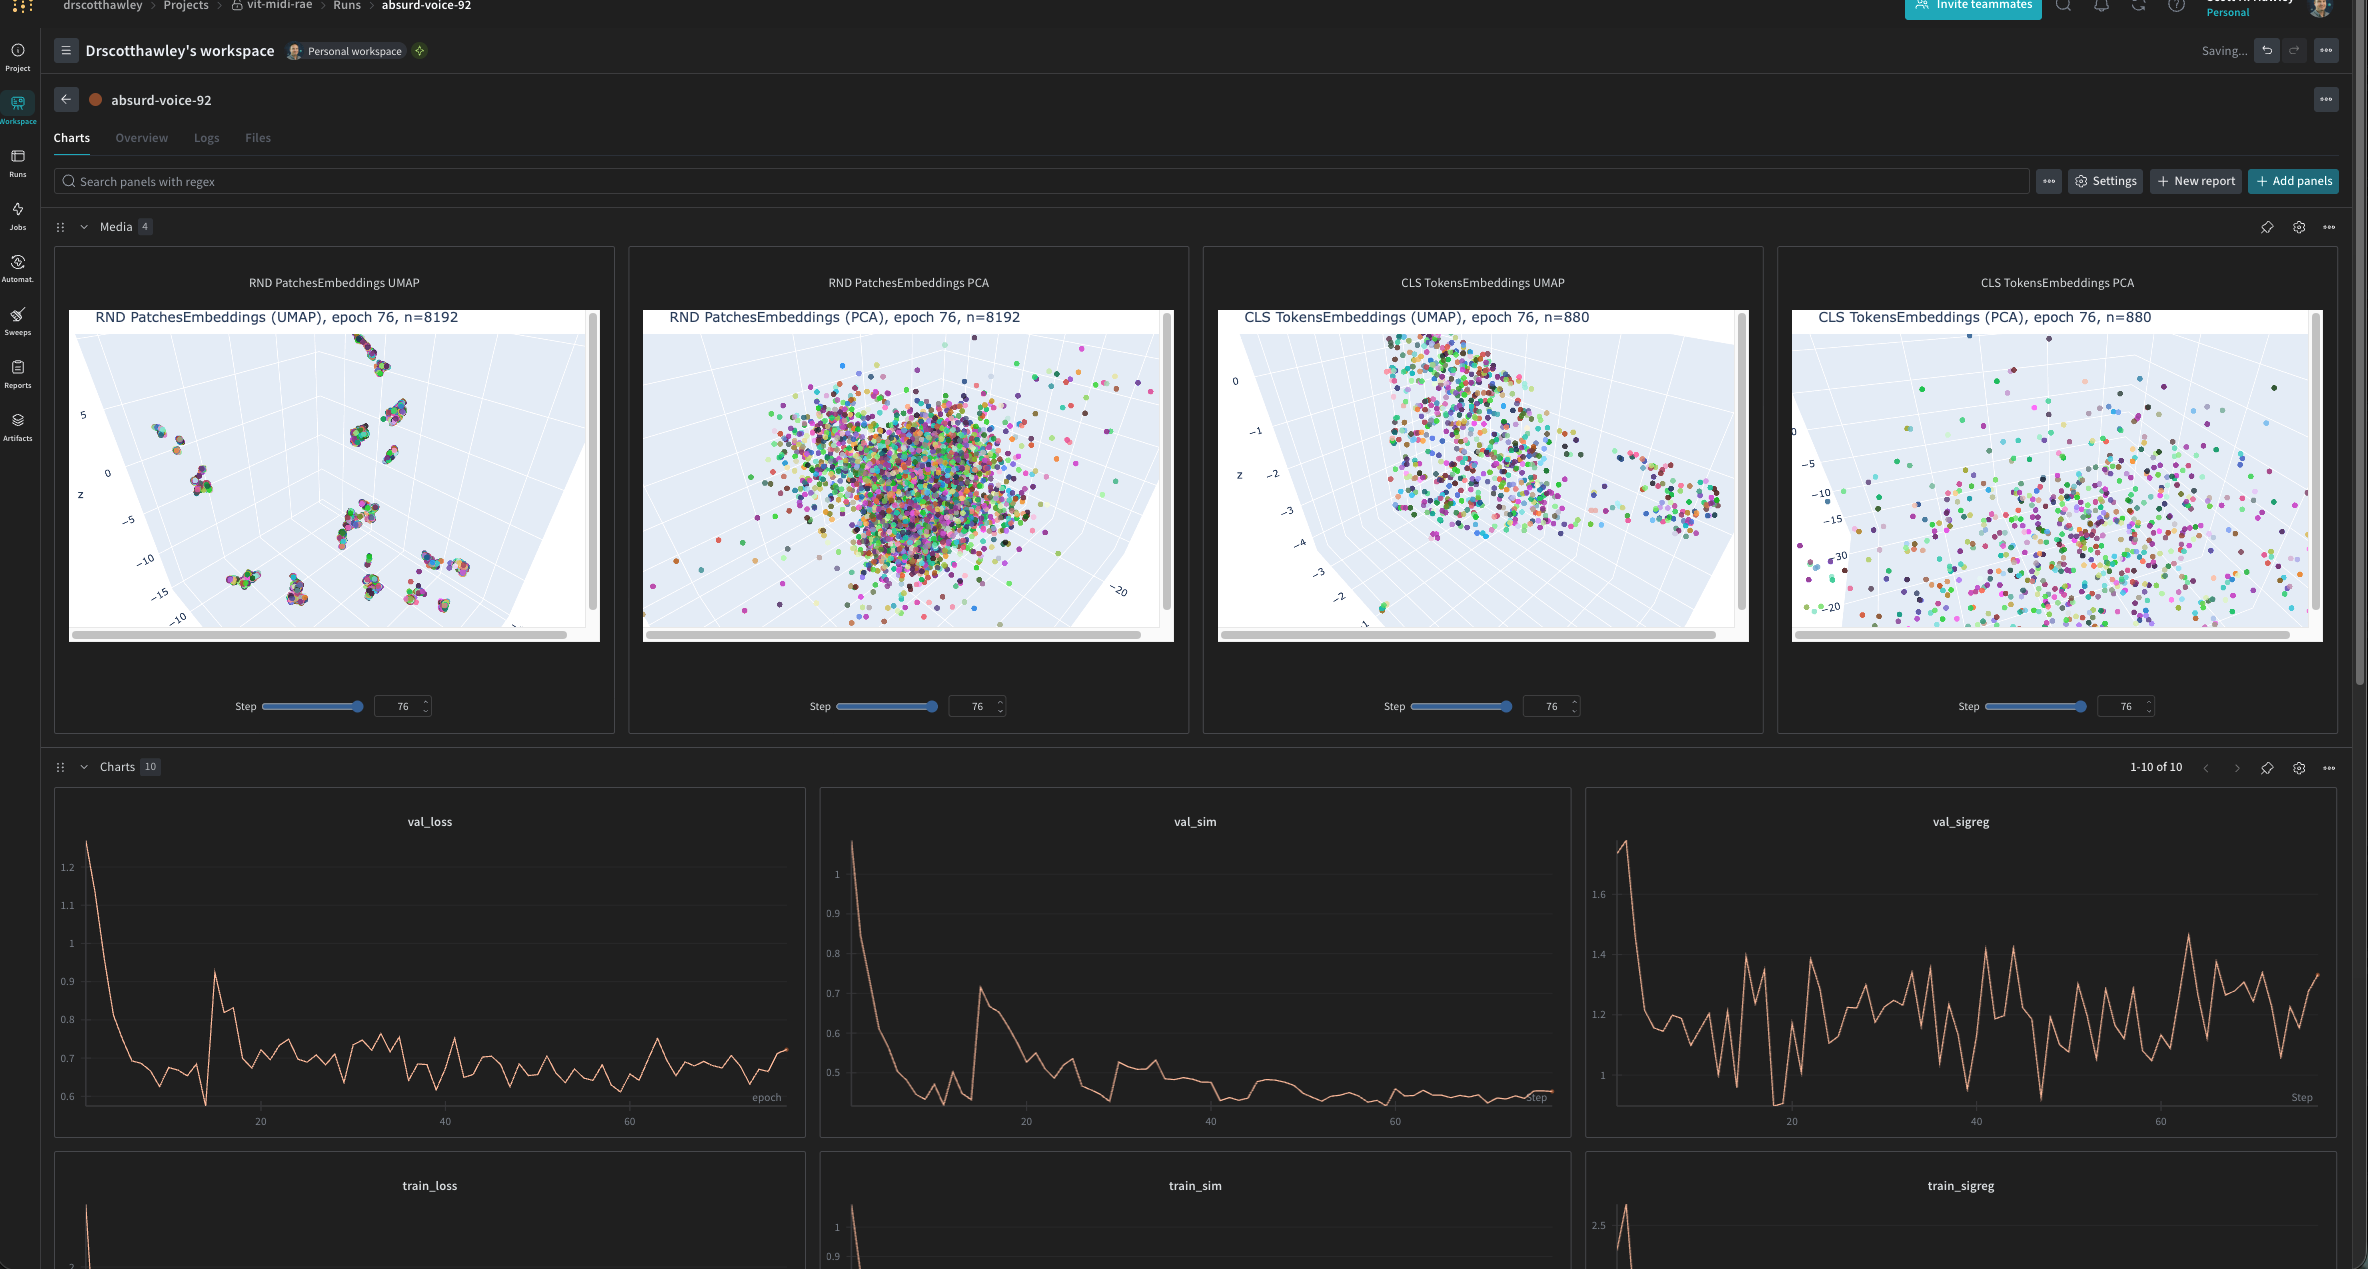

I'm not really noticing the dots of light colors being super close together except for the UMAP cases where probably anything goes. If I increase the scale of sigreg, then the scale of the sim loss goes up. I'm not really sure what it's doing, I guess is what I would will say here. And it's not obvious to me that it's working. I felt like I kind of had a handle on it when we were only doing the CLS tokens. But that's not going to be sufficient for reconstruction, at least not as far as the RAE way of doing things is.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Valid concern. A few thoughts:

The flat loss curves and scattered patches might mean: (1) the curriculum is too easy still, (2) patch-level LeJEPA isn't the right objective for this data, or (3) it's actually working but patch structure is just different from CLS structure.

One question: do you *need* to follow RAE exactly? For sparse binary MIDI images, a simpler approach might work — train the decoder directly on reconstruction loss without pre-training patch embeddings. Skip the LeJEPA patch objective entirely, just use your CLS-trained encoder + decoder.

What's your gut say?

Well, the goal is certainly representation learning of some kind. I want something where I can use the latent space both for generation and for music understanding My hope is that the patch embeddings correspond to some kind of Dictionary of musical motifs. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

That's a great goal — a learned "vocabulary" of musical patterns.

But LeJEPA's objective (attract similar crops) doesn't explicitly encourage discrete motif-like structure. It just pulls similar views together.

For a dictionary of motifs, you might want something like **VQ-VAE** — it learns a discrete codebook where each patch gets assigned to one of K learned embeddings. That's more explicitly a "dictionary."

Does that direction interest you, or do you want to push further with the current approach first?

No, no, no, no, no. I already worked for a very long time on that. It didn't work out very well. I even did residual vector quantization. That was a year ago. No, why I'm excited about the RAE paper is because of what didn't work before.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Got it — you've been down that road. Let's stick with RAE.

So the question is: how do we get meaningful patch embeddings with LeJEPA? A few ideas:

1. **Ramp curriculum faster** — get to larger shifts sooner so patches see more diverse content
2. **Only train patches that actually differ** — skip attraction loss for patches that overlap completely
3. **Different attraction weighting** — patches at image edges see more change with shifts than center patches

Or maybe just be patient and let training continue as curriculum ramps up?

We're guaranteed that none of the patches overlap completely, aren't we? Based on the way the data set mandates a shift of at least one.?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Right — with minimum shift of 1, no patch pair is 100% identical. But at 1-pixel shift, corresponding patches share ~94% of pixels (15×16 out of 256 in one direction). Almost identical.

The meaningful learning probably starts when shifts get large enough that patches see substantially different content.

Well, if you'll notice from that screenshot, I'm on epoch 76, where the maximum shift has moved up to 7.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Ah, so shift=7 means patches share only about half their pixels now. And the loss is still flat with scattered embeddings.

That's more concerning — it suggests the model might not be learning meaningful patch-level structure despite seeing diverse enough inputs.

What does the sim loss look like at this point? If it's still very low, patches are being mapped close together but maybe in a degenerate way.

Didn't I just include a screenshot that showed you the sim loss?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You're right, sorry — I can see val_sim and train_sim in the charts. They look flat and low, hovering near the bottom. That suggests patches are being pulled together, but the flat sigreg with spikes is odd.

Are the spikes in val_sigreg concerning you, or is it the overall flatness?

Yes, they are concerning to me. and the overall flatness. And the fact that when I look at the dots, they're not near each other. I wonder if I need more transformer blocks. I've currently got four and I have 8 heads

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Before adding capacity — let me check: when you reshaped to `(B*65, 768)` and did `repeat_interleave` on deltas, are you sure patch i from crop 1 is pairing with patch i from crop 2?

The reshape flattens all patches from all images together. If z1 and z2 are being concatenated or processed in a way that misaligns the pairing, the attraction loss would be pulling unrelated patches together.

Can you double-check how z1 and z2 are structured when they hit `attraction_loss`?

Sure. How do you suggest I check that?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Add a quick print right before the LeJEPA call:

```python
print(f"z1: {z1.shape}, z2: {z2.shape}, deltas: {deltas.shape}")
```

Then confirm: are z1 and z2 both `(B*65, 768)` with the same B? And deltas after repeat_interleave is `(B*65, 2)`?

Well yeah, those things have to line up or else the multiplication wouldn't go through. Although that doesn't necessarily guarantee that the interleave is in the right order, just that it produces the right shape.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good point. You could verify the actual alignment with a simple test — check that z1[0] and z2[0] come from the same image:

```python
# After reshape, before LeJEPA:
print(f"z1[0,:5]: {z1[0,:5]}")
print(f"z2[0,:5]: {z2[0,:5]}")
```

If they're similar (same image, small shift), the values should be close. If wildly different, something's misaligned.

Aren't you begging the question of whether the model is fully trained.???

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Ha, fair point. If it's not trained, they won't be similar regardless of alignment.

Better check: verify the *indices* line up correctly before the model even touches them. After reshape, does `z1[0:65]` all come from the same image, and does `z2[0:65]` come from that image's pair? That's a data pipeline question, not a model quality question.

None of this is how to get to it. We need to prescribe some kind of encoded ordering. And then see if as a result of the stacking or whatever, that the new values come up okay. Like we could just do sequential integers and then run it through the stacking and reordering

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Right — create dummy tensors with known values:

```python
# Simulate batch of 2 images, 65 tokens each
z1 = torch.arange(2*65).reshape(2, 65, 1).float()  # image 0: 0-64, image 1: 65-129
z2 = z1 + 1000  # offset so we can tell them apart
```

Then run through your reshape and see if `z1[0]` pairs with `z2[0]`, `z1[65]` pairs with `z2[65]`, etc. Want to try that?

you're talking about the reshaping here? 
```python
def compute_batch_loss(batch, model, cfg, global_step): 
    "Compute loss and return other exal auxiliary variables (for train or val)"
    device = next(model.parameters()).device
    img1, img2, deltas = batch['img1'].to(device), batch['img2'].to(device), batch['deltas'].to(device)
    z1 = model(img1, return_cls_only=False) 
    z2 = model(img2, return_cls_only=False) 
    z1 = z1.reshape(-1, z1.shape[-1])
    z2 = z2.reshape(-1, z2.shape[-1])
    num_tokens =  z1.shape[0] // len(deltas)  # or just 65
    deltas = deltas.repeat_interleave(num_tokens, dim=0)
    loss_dict = LeJEPA(z1, z2, global_step, deltas=deltas, lambd=cfg.training.lambd)
    return loss_dict, z1, z2, num_tokens
```
or somewhere else?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yes, that reshape. Looking at it now though, it actually looks correct:

- `z1` before: `(B, 65, 768)` — token j of image i is at `z1[i, j]`
- `z1` after: `(B*65, 768)` — token j of image i is at `z1[i*65 + j]`

Same for z2. So `z1[k]` and `z2[k]` are the same token position from the same image pair. And `deltas.repeat_interleave(65)` replicates each image's delta 65 times to match.

The alignment looks fine. So the issue is elsewhere — maybe the objective itself, or model capacity as you suggested.

In [ ]:
# Simulate batch of 2 images, 65 tokens each
import torch 
z1 = torch.arange(2*65).reshape(2, 65, 1).float()  # image 0: 0-64, image 1: 65-129
z2 = z1 + 1000  # offset so we can tell them apart

print("before: z1.shape = ",z1.shape)
print("z1[0,:10] = ",z1[0,:10])
print("z2[0,:10] = ",z2[0,:10])

z1 = z1.reshape(-1, z1.shape[-1])
z2 = z2.reshape(-1, z2.shape[-1])

print("after: z1.shape = ",z1.shape)
print("z1[:10] = ",z1[:10])
print("z2[:10] = ",z2[:10])

before: z1.shape =  torch.Size([2, 65, 1])
z1[0,:10] =  tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])
z2[0,:10] =  tensor([[1000.],
        [1001.],
        [1002.],
        [1003.],
        [1004.],
        [1005.],
        [1006.],
        [1007.],
        [1008.],
        [1009.]])
after: z1.shape =  torch.Size([130, 1])
z1[:10] =  tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])
z2[:10] =  tensor([[1000.],
        [1001.],
        [1002.],
        [1003.],
        [1004.],
        [1005.],
        [1006.],
        [1007.],
        [1008.],
        [1009.]])


Does that help answer your question?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yes — the alignment is correct. `z1[k]` pairs with `z2[k]` as expected.

So the issue isn't data alignment. It's either:
1. Model capacity (4 blocks might not be enough)
2. The LeJEPA objective doesn't work well at patch level
3. Lambda balance between sim and sigreg

You mentioned trying more transformer blocks — that's a reasonable next experiment.

Keep the number of heads at eight? or?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

8 heads with 768 dim gives 96-dim per head — that's standard. Keep it for now.

Try increasing depth (say, 6 or 8 blocks) and see if that helps before changing heads.

Oh, it occurs to me that since a lot of the piano roll music is concentrated in the middle range of notes, with the very low pitches and very high pitches not being activated, that means a lot of those patches are going to see all zeros. So a lot of the model may learn to kind of cheat somehow. We could just grab the middle band of notes. Say if you were to break up the image into vertically into thirds, you take the middle third, but then you've no longer got a square image. I don't know. Just thinking.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good observation — empty patches learning trivial mappings could dilute the signal. A few options:

1. **Crop middle third** → resize back to square
2. **Mask empty patches** from the loss (only train on patches with content)
3. **Random pitch shift augmentation** during training to move content around

Option 2 seems cleanest — you'd skip attraction loss for patch pairs where both are all zeros.

What's your inclination?

1. We can't crop in resize. The size of a pixel means something very specific
2. That's an interesting idea. How would we measure whether a patch is zero or not? Our patches are being generated by a learned 2D convolutional filter. Oh, I guess we could check to see if the patch is just all the same value.
3. Oh right, I thought that our random vertical shifts accounted for that, but that's just between the first image and the second image. We could randomly transpose the first image and then shift The second image relative to that. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

For option 2: you'd check the *input image patches*, not the embeddings. Something like:

```python
# Before the conv: check if each 16x16 patch region in the image is constant
patches = img.unfold(2, 16, 16).unfold(3, 16, 16)  # extract patches
is_empty = (patches.std(dim=(-1,-2)) < threshold)  # per-patch
```

Then use that mask to zero out the attraction loss for those positions.

Option 3 is also appealing — it'd force all patches to eventually see content. Which feels more natural for your data?

It's a nice idea. It's almost midnight. I have to stop, unfortunately. Hold that thought.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Sounds good — we've made solid progress today. Rest well, and we'll pick up the patch masking idea next time!

Just a thought before we're going to bed. When we're comparing patches from nearby views. We could invalidate the same patch in both of the views if either one of them are all zeros.  Or we could only invalidate if they're both all zeros. I'm not sure which makes more sense.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

If one patch is empty and the other has content (because the shift moved notes in/out), attracting them would teach "empty = content" — that seems bad.

I'd go with: invalidate if *either* is empty. Only attract pairs where both patches have meaningful content.

Sleep on it though!

```python
class PatchEmbedding(nn.Module):
    def __init__(self, 
                in_channels=1,  # 1 for solo piano, for midi PR's, = # of instruments
                patch_size=16,  # assuming square patches, e.g. 16 implies 16x16
                dim=768):       # embedding dimension
        super().__init__()
        self.conv = nn.Conv2d(in_channels, dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x, return_mask=False):  # x: (batch, channels, height, width)
        assert all(s % self.conv.kernel_size[0] == 0 for s in x.shape[-2:]), \
            f"Image size {x.shape[-2:]} must be divisible by patch_size {self.conv.kernel_size[0]}"
        conv_patches = self.conv(x).flatten(2).permute(0,2,1)
        if not return_mask: return conv_patches    # (B, num_patches, dim)  
        # Before the conv: check if each 16x16 patch region in the image is constant
        k = self.conv.kernel_size[0]
        patches = x.unfold(2, k, k).unfold(3, k, k)  # extract patches
        is_empty = (patches.amax(dim=(-1,-2)) < 0.5)  # per-patch. 1 = empty patch, 0 = non-empty
        return conv_patches, is_empty.squeeze(1).flatten(1)        
```

....how's that? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Looks good! The `amax < 0.5` check makes sense for binary images — any patch with at least one active pixel will have max ≥ 1.0.

One small thing: the `is_empty` shape after `squeeze(1).flatten(1)` should be `(B, 64)` to match `(B, num_patches)`. Want to verify with a quick test?

My questions. 
1. explain the `patches = x.unfold(2, k, k).unfold(3, k, k)` part. that baffles me. what does that do.
2. why are we using std instead of, say, max, or sum even? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

**1. `unfold`:**
`x.unfold(dim, size, step)` extracts sliding windows along dimension `dim`. With `size=step=k`, you get non-overlapping chunks.

- `x.unfold(2, k, k)` — slices along height (dim 2) into k-sized chunks
- `.unfold(3, k, k)` — then slices along width (dim 3)

Result: `(B, C, num_patches_h, num_patches_w, k, k)` — each patch is a k×k block.

**2. `std` vs `max`/`sum`:**
`std` detects *constant* patches, not just zeros. A patch of all 0.5s is also "empty" semantically — no variation, no information. `max` or `sum` would miss that case.

Does that clarify?

yea but it'll be weird trying to calibrate std for, say a patch that's all empty except for one pixel.  sum < 1 or max < 1 would catch that

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good point — for sparse binary images, `max < 0.5` (no active pixels) is cleaner and more intuitive than trying to calibrate `std`. Go with that.

can you check the data routine in `midi-rae/data.py` to see if there's any normalization applied upon loading?  e.g. are the images 0 to 1 or -1 to 1? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>view(path='midi_rae/data.py')</summary>

```json
{
  "id": "toolu_01KvNAJHhKWRYD78L6qQZzFW",
  "call": {
    "function": "view",
    "arguments": {
      "path": "midi_rae/data.py"
    }
  },
  "result": "'\"\"\"data handling routines\"\"\"\\n\\n# AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/01_data.ipynb.\\n\\n# %% auto #0\\n__all__ = [\\'PRPairDataset\\']\\n\\n# %% ../nbs/01_data.ipynb #b96051a7\\nimport os \\nfrom torch.utils.data import Dataset\\nfrom glob import glob \\nimport random\\nfrom PIL import Image\\nimport numpy as np\\nimport torch\\n\\n# %% ../nbs/01_data.ipynb #a164c279\\nclass PRPairDataset(Dataset):\\n    \"piano roll pair dataset\"\\n    def __init__(self, \\n            image_dataset_dir=\\'~/datasets/POP909_images/\\', \\n            crop_size=128, \\n            max_shift_x=10, \\n            max_shif<TRUNCATED>"
}
```

</details>

Images are normalized to **0 to 1**:
```python
img = torch.from_numpy(img).float() / 255.0
```

So `max < 0.5` would work — any patch with no active pixels will have max of 0.

So I'm currently excluding the empty patches from the traction loss. Should they also be excluded from the sigreg loss? 
Because it seems like otherwise the sigreg loss is gonna try to map a bunch of these empty cells or empty patches towards a Gaussian distribution when, in theory, they should be mapping to a single point.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good insight — yes, exclude them from SIGReg too. Empty patches are identical inputs, so they *should* map to the same point. Forcing them toward a Gaussian would fight the correct behavior.

Yeah, because I noticed that when we were only training on CLS tokens, the algorithm worked really well. Then when we started adding lots of different patch embeddings, things got really terrible. And given that the images really are largely empty space, I think we were asking the model to do the impossible given the large number of empty patches.

And now it looks like we're still visualizing an awful lot of the untrained tokens. So I need to exclude them from the visualization routine as well.  One way to do that is to alter the `compute_batch_loss` function in the training script so that it computes z1_valid, z2_valid, and deltas_valid early on, So that the non-valid ones are completely discarded from any aspect of subsequent execution Downside to that is when we're trying to do reconstruction we would still need those empty tokens.... Oh, fudge.  Yeah, we still want to be able to do reconstruction.  But currently we're not training empty patches to map to anything at all. So even though they're not in the loss, they're probably coming out as random embeddings? 

What should we do about that? Should we define some constant value such as zero and just have a purely attractive loss that applies wherever. pmask=0 ("invalid" points)? But then not pass those points into the Sig rig loss... And maybe include or don't include them in the visualization. or do a separate visualization for empty patches

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

That's a smart catch. For reconstruction, you need empty patches to have *consistent* embeddings — not random, not Gaussian-spread.

Your intuition is right: add a separate "anchor" loss for empty patches that pulls them toward a fixed point (like the zero vector). That way:
- SIGReg: non-empty patches only
- Attraction loss: non-empty pairs only  
- Anchor loss: empty patches → zero

Sound reasonable?

Okay, one other nuance: I was passing in just a single composite P mask for when other whenever patch1 or patch2 is empty, 
But in order to do the anchor loss, we need both pmasks to apply individually to patch one or  patch two.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Right — you'd need `pmask1` and `pmask2` separately so you can:
- Attraction: `~pmask1 & ~pmask2` (both non-empty)
- Anchor: `z1[pmask1] → 0` and `z2[pmask2] → 0` individually
- SIGReg: concat only non-empty from both

Does that match what you're thinking?

so something like... 
```python
def compute_batch_loss(batch, model, cfg, global_step): 
    "Compute loss and return other exal auxiliary variables (for train or val)"
    device = next(model.parameters()).device
    img1, img2, deltas = batch['img1'].to(device), batch['img2'].to(device), batch['deltas'].to(device)
    z1, pmask1 = model(img1, return_cls_only=False) 
    z2, pmask2 = model(img2, return_cls_only=False) 
    #pmask = pmask1 & pmask2  # true where both patches are non-empty 
    z1 = z1.reshape(-1, z1.shape[-1])
    z2 = z2.reshape(-1, z2.shape[-1])
    num_tokens =  z1.shape[0] // len(deltas)  # or just 65
    deltas = deltas.repeat_interleave(num_tokens, dim=0)
    loss_dict = calc_loss(z1, z2, global_step, deltas=deltas, lambd=cfg.training.lambd, pmasks=(pmask1, pmask2))
    return loss_dict, z1, z2, num_tokens
```

```python
def anchor_loss(z1, z2): 
    # anchor embeddings of empty patches to the origin
    return z1.square().mean() + z2.square().mean() 
```

```python
def calc_loss(z1, z2, # embeddings of two different "views"
    global_step,   # traing step, just used to init RNG 
    lambd=0.5,     # mixing between SIGReg (->1) and attraction (->0) parts 
    deltas=None,   # distances in pixel space that two views were shifted
    pmasks=(None,None),   # patch masks, 1 = non-empty, 0 = empty so exclude from loss
    lambda_anchor=1.0):
    pmask1, pmask2 = pmasks 
    pmask = pmask1 & pmask2 
    valid = pmask.view(-1).bool() if pmask is not None else slice(None)  # only compute losses where pmask=1 (if given)
    lj_loss = LeJEPA(z1[valid], z2[valid], deltas[valid],...etc ... )
    aloss = anchor_loss(z1[~pmask1.view(-1).bool()], z2[~pmask2.view(-1).bool()]) 
    loss =  lj_oss | {'anchor':aloss} 
    loss['loss'] += lambda_anchor*aloss
    return loss
```
...eh? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Looks like the right approach! A couple things to check:

1. `pmask1` and `pmask2` are `(B, 64)` but `z1`/`z2` after reshape are `(B*65, 768)` — you'll need to flatten pmasks and handle the CLS token (which has no pmask entry).

2. How do you want to handle CLS in the anchor loss? It's not empty, so probably exclude it?

1. Okay, the shape stuff kind of hurts my brain a bit. I thought we already did the view minus one on P mask.  So I thought I was already taken care of it
2. Yeah, the mask entry for CLS token is all ones, so it will naturally be excluded by the negation. Want it?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

1. The issue: `pmask` from PatchEmbedding is `(B, 64)` but z after reshape is `(B*65, 768)` — the CLS adds one extra token per image. Have you already prepended a "1" to each pmask for the CLS position?

2. If CLS mask is 1 (non-empty), then `~pmask` will be 0 for CLS — so it won't go into anchor loss. That sounds right.

1. yes  scrape `midi_rae/vit.py` to verify 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>view(path='midi_rae/vit.py')</summary>

```json
{
  "id": "toolu_01QC56tFp17oEXAf1K1RCHzN",
  "call": {
    "function": "view",
    "arguments": {
      "path": "midi_rae/vit.py"
    }
  },
  "result": "'\"\"\"Components & defs for ViT-based Encoder & Decoder\"\"\"\\n\\n# AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/02_vit.ipynb.\\n\\n# %% auto #0\\n__all__ = [\\'RoPE2D\\', \\'Attention\\', \\'TransformerBlock\\', \\'PatchEmbedding\\', \\'ViTEncoder\\', \\'Unpatchify\\', \\'ViTDecoder\\']\\n\\n# %% ../nbs/02_vit.ipynb #b96051a7\\nimport torch\\nimport torch.nn as nn\\nimport torch.nn.functional as F \\n\\n# %% ../nbs/02_vit.ipynb #624570b6\\nclass RoPE2D(nn.Module):\\n    def __init__(self, head_dim):\\n        super().__init__()\\n        i = torch.arange(0, head_dim // 4)\\n        self.register_buffer(\\'ifreq\\', 1.0 / (10<TRUNCATED>"
}
```

</details>

Confirmed — in `ViTEncoder.forward()`:

```python
pmask = torch.cat([pmask.new_ones(pmask.shape[0], 1), pmask], dim=1)
```

CLS gets a "1" prepended, so pmask is `(B, 65)` matching z's `(B, 65, 768)`. You're good.

So we're all good? Module O, my changes to the training script and filling in the stuff for the Legeppa loss?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Looks good to me! The shapes line up, CLS is handled, and the logic makes sense:
- LeJEPA on valid (both non-empty)
- Anchor on empty patches → zero
- SIGReg should also use only valid tokens (make sure that's in there)

Ready to test it?

Wow, so I'm now measuring the percentage of non-empty patches. It's around 35%. Which means that sixty-five percent of the images of the patches are empty. Which means I really was asking the model to do the impossible. Back when we were just using CLS tokens, life was much simpler. And if we were doing regular photos like ImageNet or whatever, we wouldn't have to worry about these empty patches. It's a quirk of the MIDI data we're using


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

That explains a lot! With 65% empty patches, you were essentially asking SIGReg to spread garbage into a Gaussian while attraction pulled identical empty patches together. No wonder it wasn't working.

Now with proper masking, you're training on the meaningful 35%. Should be a much cleaner signal. How's it looking?

It's okay, although the visualization is still showing all the empty patches. I'm not sure what value to use for the lambda for the anchor. take a  look at two files for me: `midi_rae/losses.py` and `midi_rae/viz.py`. For the vis routine, I'm considering excluding or do a similar valid indexing kind of thing before plotting the points, what do you think about that?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>view(path='midi_rae/losses.py')</summary>

```json
{
  "id": "toolu_015wCipJsLT5EioMze1CF5aY",
  "call": {
    "function": "view",
    "arguments": {
      "path": "midi_rae/losses.py"
    }
  },
  "result": "'\"\"\"LeJEPA, GAN discriminator, ...aand more\"\"\"\\n\\n# AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/03_losses.ipynb.\\n\\n# %% auto #0\\n__all__ = [\\'SIGReg\\', \\'attraction_loss\\', \\'LeJEPA\\', \\'anchor_loss\\', \\'calc_enc_loss\\', \\'PatchGANDiscriminator\\']\\n\\n# %% ../nbs/03_losses.ipynb #b96051a7\\nimport torch\\nimport torch.nn as nn\\n\\n# %% ../nbs/03_losses.ipynb #a164c279\\ndef SIGReg(x, global_step, num_slices=256):\\n    \"\"\"SIGReg with Epps-Pulley statistic. x is (N, K) tensor.\"\"\"\\n    device = x.device\\n    g = torch.Generator(device=device).manual_seed(global_step)\\n    proj_shape = (x.size(1)<TRUNCATED>"
}
```

</details>



<details class='tool-usage-details'>
<summary>view(path='midi_rae/viz.py')</summary>

```json
{
  "id": "toolu_01CGiCnYw3MJb8nQjb22p5HZ",
  "call": {
    "function": "view",
    "arguments": {
      "path": "midi_rae/viz.py"
    }
  },
  "result": "'\"\"\"vizualization routines\"\"\"\\n\\n# AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/05_viz.ipynb.\\n\\n# %% auto #0\\n__all__ = [\\'cpu_umap_project\\', \\'cuml_umap_project\\', \\'umap_project\\', \\'cuml_pca_project\\', \\'cpu_pca_project\\', \\'pca_project\\',\\n           \\'plot_embeddings_3d\\', \\'make_emb_viz\\']\\n\\n# %% ../nbs/05_viz.ipynb #b96051a7\\nimport torch\\nimport numpy as np\\nimport wandb\\nimport gc\\n\\n# %% ../nbs/05_viz.ipynb #a164c279\\ndef cpu_umap_project(embeddings, n_components=3, n_neighbors=15, min_dist=0.1, random_state=42):\\n    \"Project embeddings to n_components dimensions via UMAP (on<TRUNCATED>"
}
```

</details>

Code looks good. For visualization, I'd suggest filtering to valid patches only:

```python
patch_only = zs[torch.arange(len(zs)) % num_tokens != 0]
if pmask is not None:
    patch_pmask = pmask[:, 1:].flatten()  # exclude CLS column
    patch_only = patch_only[patch_pmask]
```

For `lambda_anchor`: start with something small like 0.1 and see if the anchor loss converges. If empty patches still wander, increase it. The anchor loss is simpler than LeJEPA, so it shouldn't need as much weight.

Ah, for a minute I was confused while I was still seeing 8192 random patch embeddings. But the full number of patch embeddings is around 57,000.  and 30% of that is still well above 8192!

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Ha, exactly! 35% of 57k ≈ 20k valid patches — still plenty to subsample from. So the visualization is fine, you're just seeing valid patches now. 👍

Wow, a lot of special stuff to handle these MIDI images.
Crazy thing was, this whole representation method of mine just stemmed from grabbing somebody's image-based diffusion code and finding it could do a great job at arbitrary in painting if I trained it on MIDI piano roll images.  But now that I'm trying to do the RAE thing and we're using the VIT with the patch embeddings, that's where things have gotten really kind of convoluted and tricky.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yeah, the sparsity of MIDI data really doesn't match what these vision architectures were designed for — dense natural images where every patch has meaningful content. You've essentially had to build custom handling for 65% of your data being "nothing."

Still, once this encoder training stabilizes, you'll have something purpose-built for your domain. That could be worth the effort.

Yeah, plenty of other people would say, why are you doing this? This is such a weird way of going about it. Especially since the piano rolls are so sparse.  But again, a lot of us in the music world, we tend to take our cues either from the image area of machine learning or the language side of machine learning. And I just found that the 2D representations from the piano roll images had a lot of nice sort of prior knowledge encoded already. Whereas, if we were to do a language-based thing using like you know, MIDI encodings, I don't know, I just found it wasn't as strong. The models, the music didn't sound as good.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Makes sense — the 2D piano roll gives you locality for free. Notes close in time *and* pitch are spatially adjacent, so convolutions naturally capture melodic/harmonic patterns. With tokenized MIDI, you lose that spatial structure and the model has to learn those relationships from scratch.

The sparsity is a quirk, but you're working through it.

Yeah, so I started with a lambda for the anchor of 1.0, even though you suggested 0.1. My hope is that the empty patches will collapse pretty early on and stabilize such that that contribution, the anchor contribution to the overall loss will fairly quickly disappear as training proceeds and the remaining loss will just be the ledge up uh loss.


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

That's reasonable — empty patches should quickly learn to map to zero since it's such a simple target. Once they're near zero, that loss term becomes negligible regardless of lambda. You can always tune it later if needed.

How's training looking so far?

We just hit epoch fifteen, which is where I increase the view shift diversity from plus or minus one pixel to plus or minus two pixels, and we saw a big spike go up in the loss. But it was temporary, and it went immediately almost back down as far as it had been before, and training is proceeding.  I might consider starting the initial shift at plus or minus 2 pixels just so that plus or minus 1 doesn't kind of overfit 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good sign that it recovered quickly — means the model is generalizing rather than memorizing the shift=1 case. Starting at shift=2 sounds reasonable to avoid that early overfitting.

Yeah, because even then that's just the maximum possible one. So we still would have a lot of plus or minus ones in there anyway, even if the max is set to two.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Exactly — the shifts are sampled uniformly in that range, so you get a mix. Starting at max=2 just ensures you never have *only* near-identical patches.

Yeah, and the shift from 2 to 3 is not as big as the shift from 1 to 2.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Right — 1→2 is a 100% increase, 2→3 is 50%. The relative jump gets smaller as you go, so the model has an easier time adapting at later curriculum stages.

Oh no, it looks like somehow this main chat somehow made it into the git history. I don't want any record of this chat ever being in the GitHub repo. I want any memory of the file throughout all commits being completely obliterated. How do we force that?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Use `git filter-repo` (preferred) or `git filter-branch`:

```bash
# Install if needed
pip install git-filter-repo

# Remove file from all history
git filter-repo --path path/to/chat-file.ipynb --invert-paths
```

Then force push:
```bash
git push --force --all
```

⚠️ This rewrites history — anyone with clones will need to re-clone. Is the repo shared with others?

I mean, I'm sharing it with myself on another machine

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Then you're fine to force push. After running `git filter-repo`, just re-clone on the other machine. What's the filename you need to remove?

literally this file we're doing right now.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>curr_dialog()</summary>

```json
{
  "id": "toolu_017zT8dpfbBKXzsRMmhuyXDh",
  "call": {
    "function": "curr_dialog",
    "arguments": {}
  },
  "result": "{'name': 'midi-rae/main_chat', 'mode': 'learning'}"
}
```

</details>

So the file is `midi-rae/main_chat.ipynb`. Run:

```bash
git filter-repo --path midi-rae/main_chat.ipynb --invert-paths --force
git push --force --all
```

```
$ git filter-repo --path midi-rae/main_chat.ipynb --invert-paths --force
Parsed 693 commits
New history written in 0.44 seconds; now repacking/cleaning...
Repacking your repo and cleaning out old unneeded objects
HEAD is now at d62343e solveit commit: Feb. 03 04:00:35 UTC
Enumerating objects: 3589, done.
Counting objects: 100% (3589/3589), done.
Delta compression using up to 48 threads
error: pack-objects died of signal 9)
fatal: failed to run repack
fatal: running 'git gc --prune=now' failed!

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Signal 9 is out of memory. Try limiting git's memory usage:

```bash
git config pack.windowMemory 100m
git gc --prune=now
```

Then force push. If that still fails, just push without gc:

```bash
git push --force --all
```

```
$ git gc --prune=now
Enumerating objects: 3589, done.
Counting objects: 100% (3589/3589), done.
Delta compression using up to 48 threads
error: pack-objects died of signal 9)
fatal: failed to run repack
solveit@9e34880b262e:~$
```
Honestly, I've been considering restarting this repository from scratch. So I think what I might do is just Copy this chat to somewhere else, delete the GitHub repo, create a new GitHub repo with the same name as the original. Copy all my notebook files in, etc. That will clean up a lot of stuff.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yeah, fresh start is often cleaner than fighting git. Just:

1. Copy this chat + any uncommitted work to a safe location
2. Delete the repo
3. Create new repo, push current files

You'll lose history but gain sanity. 👍

Oh geez, I did a really bad thing. I thought I had a backup of the repo, but apparently I didn't.   The most recent version is from yesterday, so I've lost all of today's work. Pretty much everything from where we first started checking for empty patches in the PatchEmbedding code, adding the anchor loss, updating the training script,  all the way up to excluding empty patches from the visualization. 
Would you feel comfortable making the necessary changes to the nbs/*.ipynb files, Or would you prefer to just summarize what we've done to remind me of all the things I need to do? I don't think it was that bad as far as to remwo or three lines of code here or there each. So in theory I could make the additions myself if you tell me what they were.


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Ouch, sorry to hear that! Here's a summary of the key changes:

**1. `PatchEmbedding` in `02_vit.ipynb`:**
- Add `return_mask=False` to forward
- Use `unfold` to extract patches, check `amax < 0.5` for empty
- Return `(conv_patches, is_empty)` when `return_mask=True`

**2. `ViTEncoder` in `02_vit.ipynb`:**
- Prepend a "1" to pmask for CLS: `torch.cat([pmask.new_ones(B, 1), pmask], dim=1)`

**3. `03_losses.ipynb`:**
- Add `anchor_loss(z1, z2)` — pulls empty patches to zero
- Add `calc_enc_loss()` that takes `pmasks=(pmask1, pmask2)`, applies LeJEPA only to valid pairs, anchor to empty, SIGReg to valid only

**4. `06_train_enc.ipynb`:**
- Get `z1, pmask1 = model(img1, return_mask=True)` 
- Pass `pmasks=(pmask1, pmask2)` to loss function

**5. `05_viz.ipynb`:**
- Filter random subsample to exclude empty patches using pmask

Would you like me to make these changes directly, or do you want to work through them yourself with this as a checklist?

"Use unfold to extract patches, check amax < 0.5 for empty" Tell me exactly the right line to insert. And I think going forward I will just return the mask anyway.  Uh in short, I need a more detailed summary with specific exact lines of code to use.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

**1. `PatchEmbedding.forward()` — replace the whole method:**

```python
def forward(self, x):  # x: (batch, channels, height, width)
    assert all(s % self.conv.kernel_size[0] == 0 for s in x.shape[-2:]), \
        f"Image size {x.shape[-2:]} must be divisible by patch_size {self.conv.kernel_size[0]}"
    conv_patches = self.conv(x).flatten(2).permute(0,2,1)
    # Check if each patch region in the image is empty
    k = self.conv.kernel_size[0]
    patches = x.unfold(2, k, k).unfold(3, k, k)  # extract patches
    is_empty = (patches.amax(dim=(-1,-2)) < 0.5).squeeze(1).flatten(1)  # (B, num_patches), 1=empty
    return conv_patches, ~is_empty  # return pmask: 1=non-empty, 0=empty
```

Next change?

Yes, I remember we padded the p mask with the c with ones for the C L S token in the V I T for

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

**2. `ViTEncoder.forward()` — after getting pmask from patch_embed, prepend 1 for CLS:**

```python
x, pmask = self.patch_embed(x)  # pmask: (B, 64)
pmask = torch.cat([pmask.new_ones(pmask.shape[0], 1), pmask], dim=1)  # (B, 65)
```

And return both at the end:
```python
return (x[:, 0] if return_cls_only else x), pmask
```

Next?

yes

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

**3. `03_losses.ipynb` — add anchor_loss:**

```python
def anchor_loss(z1, z2):
    "Anchor embeddings of empty patches to the origin"
    return z1.square().mean() + z2.square().mean()
```

**4. `03_losses.ipynb` — add calc_enc_loss:**

```python
def calc_enc_loss(z1, z2, global_step, deltas=None, lambd=0.5, pmasks=(None,None), lambda_anchor=1.0):
    pmask1, pmask2 = pmasks
    pmask = pmask1 & pmask2  # both non-empty
    valid = pmask.view(-1).bool()
    loss_dict = LeJEPA(z1[valid], z2[valid], global_step, deltas=deltas[valid], lambd=lambd)
    aloss = anchor_loss(z1[~pmask1.view(-1).bool()], z2[~pmask2.view(-1).bool()])
    loss_dict['anchor'] = aloss
    loss_dict['loss'] = loss_dict['loss'] + lambda_anchor * aloss
    return loss_dict
```

Next?

yep 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

**5. `06_train_enc.ipynb` — update `compute_batch_loss`:**

```python
def compute_batch_loss(batch, model, cfg, global_step): 
    device = next(model.parameters()).device
    img1, img2, deltas = batch['img1'].to(device), batch['img2'].to(device), batch['deltas'].to(device)
    z1, pmask1 = model(img1, return_cls_only=False)
    z2, pmask2 = model(img2, return_cls_only=False)
    z1 = z1.reshape(-1, z1.shape[-1])
    z2 = z2.reshape(-1, z2.shape[-1])
    num_tokens = z1.shape[0] // len(deltas)
    deltas = deltas.repeat_interleave(num_tokens, dim=0)
    loss_dict = calc_enc_loss(z1, z2, global_step, deltas=deltas, lambd=cfg.training.lambd, pmasks=(pmask1, pmask2))
    return loss_dict, z1, z2, num_tokens, pmask1, pmask2
```

Next is the viz changes?

yep

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠

**6. `05_viz.ipynb` — in `make_emb_viz`, filter patches using pmask:**

Pass pmask into the function:
```python
def make_emb_viz(zs, model, num_tokens, pmask=None, title='Embeddings', max_points=8192, epoch=None):
```

Then when getting the random subsample, filter to valid only:
```python
patch_only = zs[torch.arange(len(zs)) % num_tokens != 0]
if pmask is not None:
    patch_pmask = pmask[:, 1:].flatten()  # exclude CLS column
    patch_only = patch_only[patch_pmask.bool()]
rnd_subsample = patch_only[torch.randperm(len(patch_only))[:max_points]]
```

And update the call in `train_enc.ipynb` to pass the combined pmask:
```python
pmask = torch.cat([pmask1, pmask2], dim=0)
make_emb_viz(..., pmask=pmask, ...)
```

That's everything!

ok, and Remind me how to install `cuml`? I have CUDA 12.7. I lost my venv When I deleted the repo.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠

For CUDA 12.x, since you're using `uv`: 

```bash
uv pip install cuml-cu12 --extra-index-url https://pypi.nvidia.com
```

Uh oh: 
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/shawley/github/midi-rae/midi_rae/train_enc.py", line 10, in <module>
    import torch
  File "/home/shawley/github/midi-rae/.venv/lib/python3.10/site-packages/torch/__init__.py", line 431, in <module>
    from torch._C import *  # noqa: F403
ImportError: /home/shawley/github/midi-rae/.venv/lib/python3.10/site-packages/torch/lib/../../nvidia/cusparse/lib/libcusparse.so.12: undefined symbol: __nvJitLinkGetErrorLogSize_12_9, version libnvJitLink.so.12

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠

CUDA version mismatch. Try reinstalling torch with CUDA 12:

```bash
uv pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
```

wait why "cu121".  they don't even offer that anymore.  The lowest version is 12.6. Next one is 12.8 Since I have 12.7, I guess I should go with 12.6.?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yes, go with cu126 — it'll be compatible with your 12.7:

```bash
uv pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
```

Wow, interestingly, something's faster this time. The old version of the repo I was getting 6.24 it/2, now  it's 7.12 it/s.  Hope I didn't break anything crucial, LOL.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Nice! Probably the masking — you're now skipping 65% of patches from the LeJEPA loss computation. Less work = faster training.

Oh, I forgot that I need to log the anchor loss value to wandb.  i'll do that next. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Sounds good — just add `"train_anchor": loss['anchor']` (and similar for val) to your `wandb.log()` call.

Uh question by anchoring our empty patches to zero embeddings, is that gonna screw up the normalization somehow for other things? I don't know, for like attention or whatnot?  Granted the embeddings will probably never get mapped to exactly zero, but yeah, you know what I mean

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good question. A few thoughts:

1. **Attention**: Near-zero keys produce near-zero dot products → low attention weights. That's actually reasonable — "ignore empty patches."

2. **LayerNorm**: Should be fine unless embeddings are *exactly* zero (division by zero std). They won't be exactly zero.

3. **Decoder**: This might be the bigger concern — will the decoder learn that near-zero embeddings → empty patches?

Does the third point worry you?

Okay, thanks for that. Um I'm fairly confident that as long as the embeddings for empty patches are sufficiently grouped together, my hope is that the decoder will learn to cut things off and make empty patches. Worst case scenario, we could run the whole output through some kind of noise filter as a post-processing step.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Makes sense. The decoder sees (embedding, target image) pairs during training — if near-zero embeddings consistently pair with blank patches, it'll learn that mapping. And a simple threshold post-process is a reasonable fallback.

How's the training looking now with the anchor loss logged?

Yeah, interesting. It's going down, but it's also looking like it's flattening out. I was expecting the anchor loss part to just keep plummeting towards zero, but it seems that's not happening.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

What value is it flattening at? If it's small (like 0.01-0.1), that might be fine — embeddings are near zero but not exactly. 

If it's still high, the other losses might be fighting the anchor. What's the current anchor loss value?

Here's a screenshot. It looks like it's flattening and bouncing around close to 0.5. 


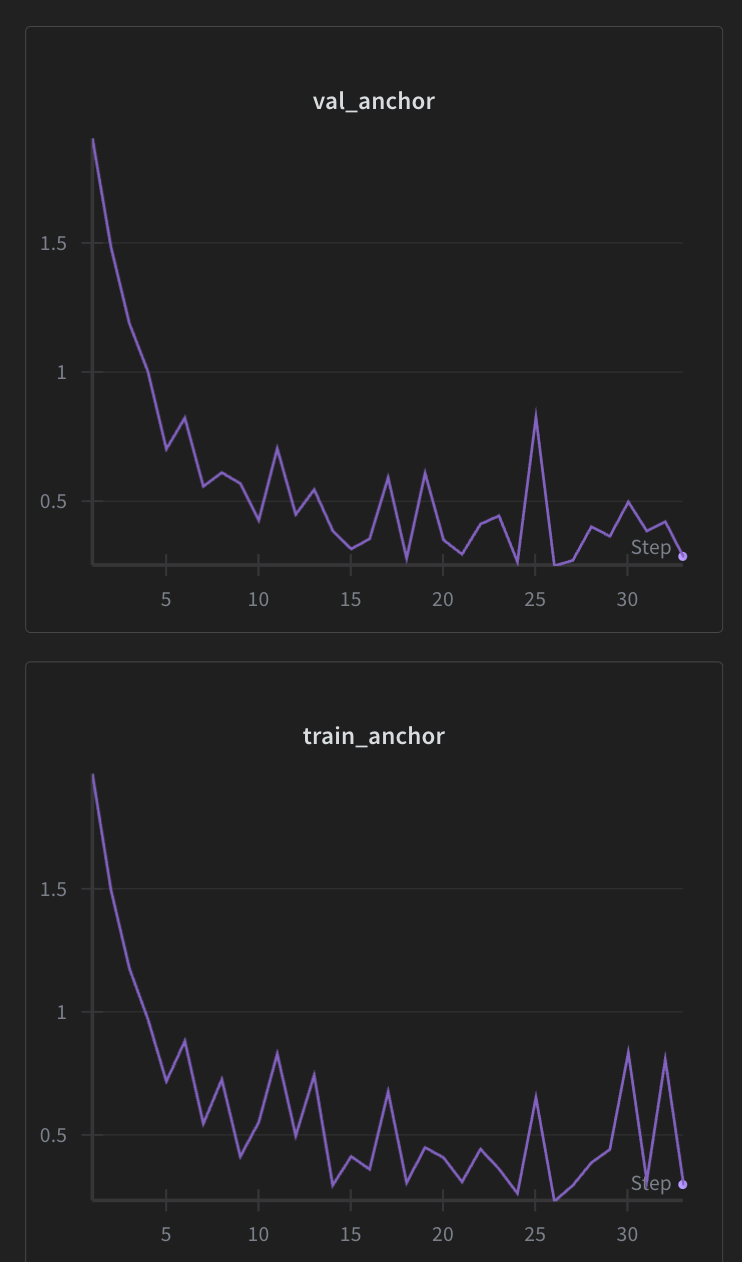


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

0.5 means average squared embedding magnitude is ~0.25 per view — so embeddings are at magnitude ~0.5 rather than near zero.

The transformer blocks might be fighting the anchor — even empty input patches get mixed with CLS and other patches through attention. 

Options:
1. Increase `lambda_anchor` (try 5 or 10)
2. Accept ~0.5 as "close enough to zero"

Which way do you want to go?

It might be a good idea to throw up a PCA plot for the embeddings of the empty patches. Probably no point running UMAP since I wouldn't expect there to be any structure. The PCA would give me an idea of kind of the rough magnitudes wouldn't it?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yes — PCA would show you the spread. If they're clustering near the origin, great. If they're spread out, the anchor isn't working well enough.

You'd just flip the mask logic to grab empty patches:
```python
empty_patches = patch_only[~patch_pmask.bool()]
```

Then run PCA on those and plot. Want to add that as a third visualization panel?

How's this? 
```python
def _make_emb_viz(zs, epoch, title='Embeddings', do_umap=True):
    "visualize embeddings, projected"
    fig = None
    if do_umap:
        coords = umap_project(zs)
        fig = plot_embeddings_3d(coords, title=title+f' (UMAP), epoch {epoch}')
    torch.cuda.synchronize() # cleanup before PCA or else you get CUDA errors
    gc.collect()
    coords = pca_project(zs)
    fig2 = plot_embeddings_3d(coords, title=title+f' (PCA), epoch {epoch}')
    if do_umap:
        wandb.log({f"{title} UMAP": wandb.Html(fig.to_html()), f"{title} PCA": wandb.Html(fig2.to_html())}, step=epoch)
    else:
        wandb.log({f"{title} PCA": wandb.Html(fig2.to_html())}, step=epoch)
    torch.cuda.synchronize() # cleanup again
    gc.collect()


def make_emb_viz(zs, model, num_tokens, epoch, title='Embeddings', max_points=8192, pmask=None):
    "this is the main routine, showing different groups of embeddings"
    device = zs.device
    model.to('cpu')
    torch.cuda.empty_cache()
    cls_tokens = zs[::num_tokens]
    _make_emb_viz(cls_tokens, epoch, title='CLS Tokens'+title)
    patch_only = zs[torch.arange(len(zs)) % num_tokens != 0] # non-cls tokens 
    if pmask is not None:
        patch_pmask = pmask[:, 1:].flatten()  # exclude CLS column
        patch_only = patch_only[patch_pmask.bool()]
        rnd_subsample = patch_only[torch.randperm(len(patch_only))[:max_points]]
        _make_emb_viz(rnd_subsample, epoch, title='RND Patches'+title)

        patch_all = zs[torch.arange(len(zs)) % num_tokens != 0]
        empty_patches = patch_all[~patch_pmask.bool()]
        rnd_subsample = empty_patches[torch.randperm(len(empty_patches))[:max_points]]
        _make_emb_viz(rnd_subsample, epoch, title='RND Empty Patches'+title, do_umap=False)
    model.to(device)
```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Looks good! Clean separation of the three views: CLS, valid patches, and empty patches. The `do_umap=False` for empty patches makes sense since you just want to see the spread around zero.

Try it out?

sure, also in make_emb_viz, We used to have a print statement that would print out the percentage of empty patches. Can you remind me what that code was? It was just a one-liner, I think.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Something like:

```python
print(f"Non-empty patches: {patch_pmask.float().mean()*100:.1f}%")
```

Right, but we also had the total number like of empty patches and versus total number of patches. There was like Yeah, that wasn't the print statement we had. Search up.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>rg(argstr='-n "print.*patch" midi_rae/')</summary>

```json
{
  "id": "toolu_01DCQKzBNywdvgDWXunnGMGX",
  "call": {
    "function": "rg",
    "arguments": {
      "argstr": "-n \"print.*patch\" midi_rae/"
    }
  },
  "result": "''"
}
```

</details>

Nothing in the current files — it was lost with the repo deletion. But based on our earlier discussion, it was probably something like:

```python
print(f"Non-empty patches: {patch_pmask.sum()}/{len(patch_pmask)} ({patch_pmask.float().mean()*100:.1f}%)")
```

Okay, I'll put that in.  yea if anchor loss is 0.5 and there are 768 dimensions,...Oh wait, never mind. We're using the mean, not the sum.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Right — so anchor loss of 0.5 means average squared value per element is ~0.25, i.e., typical embedding values around ±0.5. Not zero, but not huge either.

Why do you think they're not going down? That should be a pretty easy thing to do. And I've got the transformer is six blocks deep. I have eight heads. It it should be such a simple thing.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

The empty patches go through 6 transformer blocks of attention — they're getting mixed with the CLS and non-empty patches at every layer. By the time they come out, they've been "contaminated" by the other tokens.

The anchor loss is fighting the attention mechanism.

I wonder if there's any way we could pass a some kind of code through the system that everywhere says just ignore this or just set this to zero, etcetera.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

A couple options:

1. **Zero out after each block** — force empty patches back to zero after every transformer layer
2. **Attention masking** — prevent empty patches from attending or being attended to

Option 1 is simpler to implement — just a hook after each `TransformerBlock` that zeros out empty positions using the pmask.

Option 2 is cleaner semantically but requires passing the mask through attention.

Which direction interests you?

ok so the code in the ViT encoder looks like this: 
```python
    def forward(self, x, return_cls_only=True):
        x, pmask = self.patch_embed(x)                 # x is now patches
        cls = self.cls_token.expand(x.shape[0], -1, -1) # add cls token 
        x = torch.cat([cls, x], dim=1)
        pmask = torch.cat([pmask.new_ones(pmask.shape[0], 1), pmask], dim=1)  # (B, 65)
        for block in self.blocks:  x = block(x)
```
are you suggesting we do somthing we did earlier, with `valid = pmask.view(-1).bool()`
```python
    def forward(self, x, return_cls_only=True):
        x, pmask = self.patch_embed(x)                 # x is now patches
        cls = self.cls_token.expand(x.shape[0], -1, -1) # add cls token 
        x = torch.cat([cls, x], dim=1)
        pmask = torch.cat([pmask.new_ones(pmask.shape[0], 1), pmask], dim=1)  # (B, 65)
        for block in self.blocks:  
           x = block(x)
           x = torch.where(pmask.unsqueeze(-1), x, x * 1e-5)  # empty patches go to small but nonzero #s
```
...?  note that pmask is a bool. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Close! But `torch.where(pmask.unsqueeze(-1), x, x * 1e-5)` keeps `x` where non-empty and scales down where empty. If you want to zero them out:

```python
x[~pmask] = 0
```

or:
```python
x = x * pmask.unsqueeze(-1).float()
```

The second is cleaner and differentiable. Want to try that?

??? Did you not read my comment? I said "go to small but nonzero #s" Which means I did that intentionally. I'm concerned that making them exactly zero could cause problems elsewhere.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Apologies, I missed that! Yes, your `x * 1e-5` approach is sensible — avoids exact zeros that could cause LayerNorm issues. Your code looks correct for that intent.

Pretty sure pmask is a book by construction. or? 
```python
class PatchEmbedding(nn.Module):
    def __init__(self, 
                in_channels=1,  # 1 for solo piano, for midi PR's, = # of instruments
                patch_size=16,  # assuming square patches, e.g. 16 implies 16x16
                dim=768):       # embedding dimension
        super().__init__()
        self.conv = nn.Conv2d(in_channels, dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):  # x: (batch, channels, height, width)
        assert all(s % self.conv.kernel_size[0] == 0 for s in x.shape[-2:]), \
            f"Image size {x.shape[-2:]} must be divisible by patch_size {self.conv.kernel_size[0]}"
        conv_patches = self.conv(x).flatten(2).permute(0,2,1)
        # Check if each patch region in the image is empty
        k = self.conv.kernel_size[0]
        patches = x.unfold(2, k, k).unfold(3, k, k)  # extract patches
        not_empty = (patches.amax(dim=(-1,-2)) > 0.5).squeeze(1).flatten(1)  # (B, num_patches), 0=empty, 1=not
        return conv_patches, not_empty  # return pmask: 1=non-empty, 0=empty
```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You're right — the `> 0.5` comparison returns bool. So your original simpler version works:

```python
x = x * pmask.unsqueeze(-1)
```

Yeah, and I still want for some trickle of gradients to be able to go through.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Got it — `x * 1e-5` gives you that. Your `torch.where` line looks correct then. Try it out?

Okay, trying this out. You could kinda think of that multiplication by the small number as kind of like a funny activation function.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yeah, like a "selective damping" — non-empty patches pass through unchanged, empty ones get suppressed but not killed. Curious to see if the anchor loss drops now.

Oh, actually, now that I go back and look at the previous run that kept training, the anchor loss did get down to 0.1 After 87 epochs.  But yeah, we'll see what happens now that we're kind of helping it along.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good to know it was heading in the right direction! With the forced damping, should get there much faster. Let me know what you see.

hah! the anchor loss is 2e-10

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠

Ha! That worked. Forced damping does the trick — now the empty patches are basically at zero without fighting the attention layers.

How do the other losses (sim, sigreg) look? Any adverse effects?

Other losses look pretty "normal" As in similar to before.. Which is actually a little disappointing. I was hoping they would go down faster now that we've kinda done some of the work for them and removed some of the ambiguity.
The empty patches are still relevant for the CLS tokens as it learns kind of global structure and so forth and....  Are the positional encodings being used within each patch, or only to label the patches themselves

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

RoPE2D is applied to the patch positions in the grid (which patch is at row i, col j), not within the 16×16 pixels of each patch. The patch content is just a flat 768-d vector by the time it hits attention.

i just realized where the 768 number comes from for the dimensions of the embeddings, it's based on RGB patches.  16x16x3 = 768.  but in my application i only have grascale images, so i could probably use 256 dimensions for the embeddings. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good catch! 768 = 16×16×3 for RGB. For grayscale, 256 = 16×16×1 makes sense as a lower bound.

Tradeoffs:
- **256**: Fewer params, faster, less memory
- **Keep 768**: More capacity for learning rich representations

Worth experimenting. Want to try a run with 256 and see how it compares?

I've kept 768 for now.

Different topic. in the visualization routine where we make the plotly plots (cv `midi-rae/viz.py`), it might be good to label the points with their patch number (or patch coordinates) and file id or filename. i.e. when you mouse over the points, Plotly shows up a little window with information and you can put additional information there. if we look at `midi-rae/train_enc.py`, I think we could just get the file data that's returned from the dataloader, and just calculate the patch number or patch id.  what do you think? 


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good idea — hover labels would help you debug which files/patches are behaving oddly.

A few questions:
1. Does your dataloader currently return the filename or file index? (I can check `data.py` if needed)
2. For patch coordinates, you'd compute `(patch_idx // 8, patch_idx % 8)` for an 8×8 grid — sound right?

Want me to look at the dataloader to see what's available?

the dataset class returns a unique file index (int) which is sufficient for our needs.
```
        return {
            'img1': img1.unsqueeze(0),  # add channel dim (1, 128, 128)
            'img2': img2.unsqueeze(0),
            'deltas': torch.tensor([shift_x, shift_y], dtype=torch.float32).abs(),
            'file_idx': file_idx,
        }
```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Perfect. So you'd:
1. Pass `file_idx` from the batch through to `make_emb_viz`
2. Expand it like deltas: `file_idx.repeat_interleave(num_tokens)`
3. Compute patch coords: `patch_row = idx % num_tokens // 8`, `patch_col = idx % num_tokens % 8`

Then in `plot_embeddings_3d`, use Plotly's `hovertext` or `customdata` to show the info.

Want me to show the changes to `plot_embeddings_3d` for the hover labels?

I got that all figured out. New topic. I want to create a notebook for exploring the Encoder and other things. for exmaple, Something that will load up the data set, Load up a checkpoint of a trained encoder, Run a batch of data through the encoder, and visualize the embeddings. interactively inside the notebook.
What should we name that notebook?  09_explore.ipynb?  or maybe "eval"? Although sometimes eval implies more of like running objective scoring metrics. "analyze" seems vague... but so does "explore".  your thoughts? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

A few options:

- **explore** — implies interactive poking around, which fits
- **inspect** — suggests looking closely at what the model learned
- **sandbox** — casual/experimental feel
- **probe** — common ML term for examining representations

I'd lean toward `09_explore.ipynb` or `09_inspect.ipynb`. What resonates with you?

09_inspect.ipynb sounds good. Can you please create that, and add the code to have it do what I described? if you need to inform your context, Consider that it'll essentially be doing a subset of what the `nbs/06_train_enc.ipynb`, Except for the addition of loading the encoder checkpoint first. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>view(path='nbs/06_train_enc.ipynb')</summary>

```json
{
  "id": "toolu_01XGJjk9D3TwDRi4WeTggBn6",
  "call": {
    "function": "view",
    "arguments": {
      "path": "nbs/06_train_enc.ipynb"
    }
  },
  "result": "'{\\n \"cells\": [\\n  {\\n   \"cell_type\": \"markdown\",\\n   \"id\": \"2b916516\",\\n   \"metadata\": {},\\n   \"source\": [\\n    \"# train_enc\\\\n\",\\n    \"\\\\n\",\\n    \"> Encoder training script for midi_rae \"\\n   ]\\n  },\\n  {\\n   \"cell_type\": \"code\",\\n   \"execution_count\": null,\\n   \"id\": \"f4905c98\",\\n   \"metadata\": {},\\n   \"outputs\": [],\\n   \"source\": [\\n    \"#| default_exp train_enc\"\\n   ]\\n  },\\n  {\\n   \"cell_type\": \"code\",\\n   \"execution_count\": null,\\n   \"id\": \"1d8d15b2\",\\n   \"metadata\": {},\\n   \"outputs\": [],\\n   \"source\": [\\n    \"#| hide\\\\n\",\\n    \"from nbdev.showdoc import *\"\\n   ]\\n  },\\n  {\\n   \"cell_t<TRUNCATED>"
}
```

</details>



<details class='tool-usage-details'>
<summary>create(path='nbs/09_inspect.ipynb', file_text='{\n "cells": [\n  {\n   "cell_type": "markdown",\n   "…')</summary>

```json
{
  "id": "toolu_01K4FAnDtPUtqUFtLqy1rAHF",
  "call": {
    "function": "create",
    "arguments": {
      "path": "nbs/09_inspect.ipynb",
      "file_text": "{\n \"cells\": [\n  {\n   \"cell_type\": \"markdown\",\n   \"metadata\": {},\n   \"source\": [\"# Inspect\\n\", \"\\n\", \"> Interactive exploration of trained encoder and embeddings\"]\n  },\n  {\n   \"cell_type\": \"code\",\n   \"execution_count\": null,\n   \"metadata\": {},\n   \"outputs\": [],\n   \"source\": [\"import torch\\n\", \"from torch.utils.data import DataLoader\\n\", \"from omegaconf import OmegaConf\\n\", \"from midi_rae.vit import ViTEncoder\\n\", \"from midi_rae.data import PRPairDataset\\n\", \"from midi_rae.viz import make_emb_viz\"]\n  },\n  {\n   \"cell_type\": \"markdown\",\n   \"metadata\": {},\n   \"source\": [\"## Config\"]\n  },\n  {\n   \"ce<TRUNCATED>"
    }
  },
  "result": "'Created file /app/data/midi-rae/nbs/09_inspect.ipynb.'"
}
```

</details>

Done! Created `nbs/09_inspect.ipynb` with:
- Config loading
- Dataset loading (val split)
- Encoder checkpoint loading
- Running a batch through the encoder
- PCA visualization (interactive, no wandb)
- Sample image pair display

You can adjust the `ckpt_path` to point to your checkpoint.

I think I lost some of my local work on `viz.py` But it probably exists in my git stash. How would I search through git stash to look at changes to viz.py

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠

List your stashes:
```bash
git stash list
```

Then view changes to `viz.py` in a specific stash:
```bash
git stash show -p stash@{0} -- midi_rae/viz.py
```

Replace `stash@{0}` with the appropriate stash index from the list.

```bash
$ git stash list
stash@{0}: WIP on main: d4df4d2 fixed enc cp name
stash@{1}: WIP on main: 9c17d2f cleaned up file_idx
stash@{2}: WIP on main: 9b82cc4 ran nbdev-clean
stash@{3}: WIP on main: f8c87e7 added inspection notebook
stash@{4}: WIP on main: 73316cb solveit commit: Feb. 06 03:57:44 UTC
stash@{5}: WIP on main: 0d72bcd logging anchor
```
How do I know which stash contains the changes to the Viz?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Check each stash for viz.py changes:

```bash
for i in {0..5}; do echo "=== stash@{$i} ==="; git stash show stash@{$i} -- midi_rae/viz.py; done
```

That'll show which stashes touched `viz.py`. Then use `git stash show -p stash@{N} -- midi_rae/viz.py` on the relevant one to see the actual diff.

that didn' look like it worked: 
```bash
$ for i in {0..5}; do echo "=== stash@{$i} ==="; git stash show stash@{$i} -- midi_rae/viz.py; done
=== stash@{0} ===
Too many revisions specified: 'stash@{0}' 'midi_rae/viz.py'
=== stash@{1} ===
Too many revisions specified: 'stash@{1}' 'midi_rae/viz.py'
=== stash@{2} ===
Too many revisions specified: 'stash@{2}' 'midi_rae/viz.py'
=== stash@{3} ===
Too many revisions specified: 'stash@{3}' 'midi_rae/viz.py'
=== stash@{4} ===
Too many revisions specified: 'stash@{4}' 'midi_rae/viz.py'
=== stash@{5} ===
Too many revisions specified: 'stash@{5}' 'midi_rae/viz.py'

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Try this instead:

```bash
for i in {0..5}; do echo "=== stash@{$i} ==="; git diff stash@{$i}^..stash@{$i} -- midi_rae/viz.py 2>/dev/null | head -5; done
```

```bash
$ for i in {0..5}; do echo "=== stash@{$i} ==="; git diff stash@{$i}^..stash@{$i} -- midi_rae/viz.py 2>/dev/null | head -5; done
=== stash@{0} ===
=== stash@{1} ===
=== stash@{2} ===
=== stash@{3} ===
=== stash@{4} ===
=== stash@{5} ===


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

No viz.py changes in any stash. Maybe it's in a commit rather than stash?

```bash
git log --oneline --all -- midi_rae/viz.py | head -10
```

If it was in a commit, then the code would probably be working. My most recent run shows an error that I thought we already resolved a few days ago: 
```bash
$ tail -20 nohup.out 
Epoch 7/1000: 100%|██████████| 185/185 [00:15<00:00, 11.64it/s]
Epoch 7/1000: train_loss=4.004 val_loss=3.922
Epoch 8/1000: 100%|██████████| 185/185 [00:15<00:00, 11.77it/s]
Epoch 8/1000: train_loss=3.668 val_loss=3.530
Epoch 9/1000: 100%|██████████| 185/185 [00:15<00:00, 11.69it/s]
Epoch 9/1000: train_loss=3.456 val_loss=2.946
Epoch 10/1000: 100%|██████████| 185/185 [00:15<00:00, 11.71it/s]
Epoch 10/1000: train_loss=3.206 val_loss=2.745
Error executing job with overrides: []
Traceback (most recent call last):
  File "/home/shawley/github/midi-rae/midi_rae/train_enc.py", line 121, in train
    make_emb_viz(torch.cat((z1, z2), dim=0),  num_tokens, epoch, model=model, pmask=torch.cat([pmask1, pmask2], dim=0), file_idx=batch['file_idx'])
  File "/home/shawley/github/midi-rae/midi_rae/viz.py", line 140, in make_emb_viz
    patch_file_idx = file_idx[patch_mask] if file_idx is not None else None
IndexError: The shape of the mask [57200] at index 0 does not match the shape of the indexed tensor [440] at index 0



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

The issue: `file_idx` is `(440,)` — one per image — but `patch_mask` is `(57200,)` — one per token.

You need to expand `file_idx` before masking:
```python
file_idx = file_idx.repeat_interleave(num_tokens)
```

Where is that expansion happening in your `viz.py`?

oh weird looks like it's in a notebook but but not in the accompanying .py file?? 

```bash
(midi-rae) shawley@lecun:~/github/midi-rae$ grep repeat_interleave midi_rae/*.py
midi_rae/train_enc.py:    deltas = deltas.repeat_interleave(num_tokens, dim=0)
(midi-rae) shawley@lecun:~/github/midi-rae$ grep repeat_interleave nbs/*.py
grep: nbs/*.py: No such file or directory
(midi-rae) shawley@lecun:~/github/midi-rae$ grep repeat_interleave nbs/*.ipynb
nbs/05_viz.ipynb:    "file_idx = file_idx.repeat(2).repeat_interleave(num_tokens)  #?? no idea wtf this is. lLM suggested it\n",
nbs/06_train_enc.ipynb:    "    deltas = deltas.repeat_interleave(num_tokens, dim=0)\n",
nbs/07_inspect.ipynb:    "file_idx = file_idx.repeat_interleave(num_tokens).repeat(2)\n",

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

The notebook has the fix but `nbdev_export` wasn't run to sync it to `midi_rae/viz.py`. Run:

```bash
nbdev_export
```

Yeah, but I ran nbdev export and it didn't pick up the viz file..... Oh, because apparently we only did it in the exploratory part of the notebook, not in the actual exported code part of the notebook. .e.g...

```python
#| eval: false
#testing viz
import plotly.io as pio
pio.renderers.default = 'notebook'

bs, num_tokens, dim = 32, 65, 256
z1 = torch.randn([bs, num_tokens, dim])
file_idx = torch.arange(bs)
z2 = z1 +  0.1*torch.randn([bs, num_tokens, dim]) # z2 is slightly shifted from z1

zs = torch.cat([z1, z2], dim=0).view(-1, dim)  # flatten to [64*65, 256]
file_idx = file_idx.repeat(2).repeat_interleave(num_tokens)  #?? no idea wtf this is. lLM suggested it

pmask = torch.ones([2*bs, num_tokens])  # all ones
pmask[:, 30:] = 0  # mark roughly half the patches as empty

figs = make_emb_viz(zs,  num_tokens, title='testing', pmask=pmask, file_idx=file_idx, do_umap=False) 
figs['patch_pca_fig'].show()
```
To keep from breaking other parts of the code, what if I just put in a test like 
```
if file_index.shape[0] < zs.shape[0]: file_idx = file_idx.repeat(2).repeat_interleave(num_tokens) 
```
...?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

That would work, but be careful — `file_idx` could be `None`. Maybe:

```python
if file_idx is not None and file_idx.shape[0] < zs.shape[0]:
    file_idx = file_idx.repeat(2).repeat_interleave(num_tokens)
```

ok new error: 
```
Traceback (most recent call last):
  File "/home/shawley/github/midi-rae/midi_rae/train_enc.py", line 121, in train
    make_emb_viz(torch.cat((z1, z2), dim=0),  num_tokens, epoch, model=model, pmask=torch.cat([pmask1, pmask2], dim=0), file_idx=batch['file_idx'])
  File "/home/shawley/github/midi-rae/midi_rae/viz.py", line 151, in make_emb_viz
    valid_patches, valid_file_idx = patch_only[patch_pmask], (patch_file_idx[patch_pmask] if patch_file_idx is not None else None)
RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)
```

relevant code is this: 
```
def make_emb_viz(zs,  num_tokens, epoch=-1, model=None, title='Embeddings', max_points=8192, pmask=None, file_idx=None, do_umap=True):
    "this is the main routine, showing different groups of embeddings"
    device = zs.device
    if model is not None: model.to('cpu')
    torch.cuda.empty_cache()

    if file_idx is not None and file_idx.shape[0] < zs.shape[0]:
        file_idx = file_idx.repeat(2).repeat_interleave(num_tokens)


    # CLS tokens
    cls_tokens = zs[::num_tokens]
    cls_file_idx = file_idx[::num_tokens] if file_idx is not None else None
    cls_pca_fig, cls_umap_fig = _make_emb_viz(cls_tokens, num_tokens, epoch=epoch, title='CLS Tokens '+title, file_idx=cls_file_idx, do_umap=do_umap)

    # Patches (non-CLS)
    patch_mask = (torch.arange(len(zs)) % num_tokens != 0).cpu()
    patch_only = zs[patch_mask]
    patch_file_idx = file_idx[patch_mask] if file_idx is not None else None

    if pmask is not None:
        patch_pmask = pmask[:, 1:].flatten().bool()
        print(f"Non-empty patches: {patch_pmask.sum()}/{len(patch_pmask)} ({patch_pmask.float().mean()*100:.1f}%)")

        # Non-empty patches
        valid_patches, valid_file_idx = patch_only[patch_pmask], (patch_file_idx[patch_pmask] if patch_file_idx is not None else None)
```
As you can see, I thought I did put patch mask on the CPU.  so ..??

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

`patch_pmask` is still on GPU (from `pmask`), but `file_idx` is on CPU. Add:

```python
patch_pmask = pmask[:, 1:].flatten().bool().cpu()
```

Oh, sorry. I'd rather have everything on the GPU, to be honest. I just thought from the error message that it was expecting me to put things on the CPU. So what should I do to do that?  The reason for GPU is that some of the UMAP routines use GPU. We should just be using z's.device for everything.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Move `file_idx` to GPU after expanding it:

```python
if file_idx is not None and file_idx.shape[0] < zs.shape[0]:
    file_idx = file_idx.repeat(2).repeat_interleave(num_tokens).to(device)
```

And remove the `.cpu()` from `patch_mask`:

```python
patch_mask = (torch.arange(len(zs), device=device) % num_tokens != 0)
```

Okay, that fixed it. Now that I've decreased the memory footprint by factor 3, should I triple the batch size? Or what do you think?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You could try increasing it, but it won't be a clean 3x — attention and other ops also use memory. I'd bump it gradually (maybe 600 → 800 → 1000) and watch GPU usage until you find the new limit.

yea i increased batch_size from 440 to 768 and I"m now only seing 50% GPU usage. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Lots of headroom! Try 1024 or even 1200. Keep bumping until you hit ~85-90% usage.

oh wait wft it just jumped up to 83%.  Not sure if I've got a RAM leak or what, but I'm not going to worry about it right now. I'll just let it keep running.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Probably just took a bit for all the buffers to allocate. 83% with batch size 768 is solid — good headroom without wasting capacity. Let it run!

Okay, interesting. I'm not sure what changed specifically because I had to retune a couple hyperparameters when I switched to 256 dimensions.... But now the PCA plots are showing kind of a U-shaped data distribution rather than a Gaussian. I wonder if that's something inherent to...The lower dimensional representation or...? 256 is still a lot of dimensions, though.


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Interesting! A U-shape (sometimes called "horseshoe effect") in PCA often indicates your embeddings have learned a continuous ordering or gradient — like one dominant varying factor. 

For MIDI data, could be pitch range, note density, or something about the musical structure.

Are you seeing this on the CLS tokens, the patches, or both?

Mostly in the CLS tokens. The patches have some kind of structure, but I'm not sure what it is. Here's a screenshot of the CLS tokens projected down to 3D via PCA.  
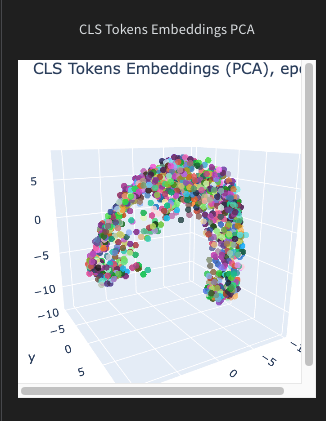



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Classic horseshoe! That U-shape usually means there's one dominant continuous factor the model has learned — the second PC becomes a nonlinear function of the first.

What do the colors represent in your plot — file_idx? If so, are similar colors grouping together along the curve?

Well, of course, this is a contrastive loss type model, so colors that are exactly the same should be drawn near each other in pairs. And then supposedly, the LeJEPA SIGReg loss is supposed to enforce a Gaussian data distribution when projected along many r.andom directions

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Right — SIGReg enforces Gaussianity on 1D slices (random projections), but that doesn't guarantee the joint distribution is Gaussian. You can have Gaussian marginals along many directions but still have non-Gaussian structure in 2D/3D.

The horseshoe suggests there's a dominant latent factor the model found, and the data lives on a 1D manifold embedded in the higher-dim space.

Is this a problem for your application, or just an interesting observation?

Well, just that when I had seven hundred and sixty eight dimensions I never noticed such a thing.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

With 768 dims, the variance spreads across more dimensions — the horseshoe might have been there but diluted across PCs 4, 5, 6, etc. With 256, the structure is more concentrated in the top few components.

Did you also change the number of transformer blocks or heads when you switched to 256?

No, I did not. All I changed was the batch size and the relative strength of the sigreg loss, which I've been tuning. So, yeah, it is true that I changed more than one thing at a time, and also due to storage requirements, I had to delete most of the record of my previous successful run at the full 768 dimensions. Not great for science, but I was forced to. Otherwise, I couldn't do any more runs with no storage.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Storage constraints are real — sometimes you have to move forward without perfect records.

The horseshoe could be from any of those changes. Does it seem to be hurting training, or is the model still learning reasonable representations?

I think it is. It's looking like points that are supposed to be close together are close to each other.
One of the things that's hurting my ability to interpret the code, is that all the patches z1 (65 of them) and z2 (another 65) are catted together via torch.cat([z1,z2]),  which means all the Z2 patches come after all the Z1 patches. But then any time I want to attach labels that go with the pairs I have to space them out and do some kind of repeat interleave type crap that confuses the heck out of me.

What might be simpler on the back end would be to not do torch.cat As I had above, but do some kind of interleaved torch.cat. so that the result is  [z1[0],z2[0], z1[1], z2[1]).  That might simplify a lot of the other code for labeling things. What do you think? How would we achieve that kind of interleaved concatenation? Should you do it through some kind of indexing scheme?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good thinking — interleaving would make pairs adjacent. You can do:

```python
torch.stack([z1, z2], dim=1).reshape(-1, z1.shape[-1])
```

That gives `[z1[0], z2[0], z1[1], z2[1], ...]`. Then labels just need `.repeat_interleave(2)` instead of the confusing repeat + interleave combos.

Want to try refactoring with that approach?

That would also mean I wouldn't have to carry around `num_tokens`, right? because currently i have, e.g. 

```
file_idx = file_idx.repeat(2).repeat_interleave(num_tokens)
```

so the new one would just be `file_idx = file_idx.repeat_interleave( zs.shape[0]//file_idx.shape[0]) `  ...or? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yes, that's right! With interleaving, adjacent tokens are pairs from the same image, so `file_idx.repeat_interleave(zs.shape[0]//file_idx.shape[0])` gives you the right expansion without needing `num_tokens`.